# Models Evaluation

In [1]:
import pickle
import matplotlib.pyplot as plt
from input_pipeline import *
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import hyperparams
from models import *
from utils import *

2021-08-27 23:50:33.163857: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# 1) 12kws task

In [2]:
current_task = hyperparams._TASKS_[0]
print(current_task)
core_kws, aux_kws, output_classes = get_kws(hyperparams._DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)

10kws+U+S
Core keywords:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

Auxiliary keywords:  ['bird', 'wow', 'sheila', 'marvin', 'four', 'dog', 'six', 'visual', 'cat', 'forward', 'learn', 'backward', 'five', 'nine', 'happy', 'follow', 'bed', 'three', 'seven', 'house', 'zero', 'two', 'tree', 'one', 'eight']

Output Classes:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'filler', 'silence']


In [3]:
if len(os.listdir(hyperparams._BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    make_and_save_original_splits(current_task, return_canonical_test_set=False)

X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task, smoke_size=-1)

batch_size = 64
train_dataset, train_steps, valid_dataset, valid_steps, test_dataset = get_tf_datasets(X_train, 
                             y_train, 
                             X_valid, 
                             y_valid, 
                             X_test, 
                             y_test, 
                             batch_size=batch_size,
                            task=current_task)

2021-08-27 23:50:35.017216: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-27 23:50:35.068908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 23:50:35.069248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-27 23:50:35.069287: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-27 23:50:35.071980: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-27 23:50:35.072075: I tensorflow/stream_executor/platf

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Train steps: 577
Validations steps: 70
Example of dataset element:
(<tf.Tensor: shape=(64, 16000), dtype=float32, numpy=
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -6.56030513e-03, -4.88266232e-04, -4.88266232e-04],
       [ 2.00335085e-01,  1.12733364e-01,  4.35615145e-02, ...,
         2.15892777e-01, -2.77644806e-02, -1.81426525e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.59980893e-01,  1.59980893e-01,  3.00620824e-01, ...,
         1.67144224e-01,  4.60601717e-01,  4.91165221e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  2.07240996e-03,  2.

2021-08-27 23:50:36.341575: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-27 23:50:36.361163: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz
2021-08-27 23:50:36.481709: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [4]:
# just iterate one time on the test set in order to create the cache file
for i in iter(test_dataset):
    pass

In [5]:
def plot_learning_curves(training_data):
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
    plt.plot(range(len(training_data['val_out_layer_loss'])), training_data['val_out_layer_loss'], label="Validation Loss")
    plt.legend(fontsize=16)

    plt.subplot(1,2,2)
    plt.plot(range(len(training_data['out_layer_accuracy'])), training_data['out_layer_accuracy'], label="Training Accuracy")
    plt.plot(range(len(training_data['val_out_layer_accuracy'])), training_data['val_out_layer_accuracy'], label="Validation Accuracy")

    plt.legend(fontsize=16)
    plt.show()

def make_confmatrix(model, test_dataset):
    y_scores, att_scores = model.predict(test_dataset.batch(batch_size))
    y_pred = np.array(np.argmax(y_scores, axis=1))
    y_true = np.array(y_test)
    # compute test accuracy
    test_acc = sum(np.equal(y_pred, y_true)) / len(y_true)
    print(f'Test set accuracy: {test_acc:.3%}')

    confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
    plt.figure(figsize=(20, 15))
    sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
                annot=True, fmt =".2f")
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.title(f"Model: {model.name}; Task: {current_task}; Accuracy: {round(test_acc*100,2)}%", fontsize=15)
    # plt.savefig(_MODELS_DIR_/current_task/f'{model.name}.png', dpi=300)
    plt.show()
    return y_scores, att_scores, test_acc

In [6]:
## this dictionary will be loaded with all the results (prediction scores, attention scores, 
# test accuracy, n_parameters of the model)

results_12kws_task = {}
results_35kws_task = {}

def update_results(results_dict, model, key_name, y_scores, att_scores, test_acc):
    fpr, fnr, roc_auc = get_fpr_fnr_aucs(y_test, y_scores, output_classes)
    results_dict[key_name] = {}
    results_dict[key_name]['y_scores'] = y_scores
    results_dict[key_name]['att_scores'] = att_scores
    results_dict[key_name]['test_acc'] = test_acc
    results_dict[key_name]['n_params'] = get_n_of_trainable_variables(model)
    results_dict[key_name]['fpr'] = fpr
    results_dict[key_name]['fnr'] = fnr
    results_dict[key_name]['roc_auc'] = roc_auc
    return results_dict

## Simple Attention RNN

In [7]:
model_simple_att = simple_attention_rnn(train_dataset, output_classes, "eval", mfccs=True)
model_simple_att.summary()

Input shape: (16000,)


2021-08-27 23:50:37.240584: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model: "simple_attention_rnn_eval"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment (RandomNoi (None, 16000)        0           input_1[0][0]                    
__________________________________________________________________________________________________
mfcc (MFCC)                     (None, 98, 40, 1)    0           random_noise_augment[0][0]       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 98, 40, 1)    4           mfcc[0][0]                       
__________________________________________________________________________

In [8]:
model_simple_att.load_weights(f"models/{current_task}/simple_attention_rnn_mfccs/weights").expect_partial()
with (open("models/10kws+U+S/andreade_original_mfccs/train_history.pkl", "rb")) as openfile:
    history_simple_att = pickle.load(openfile)

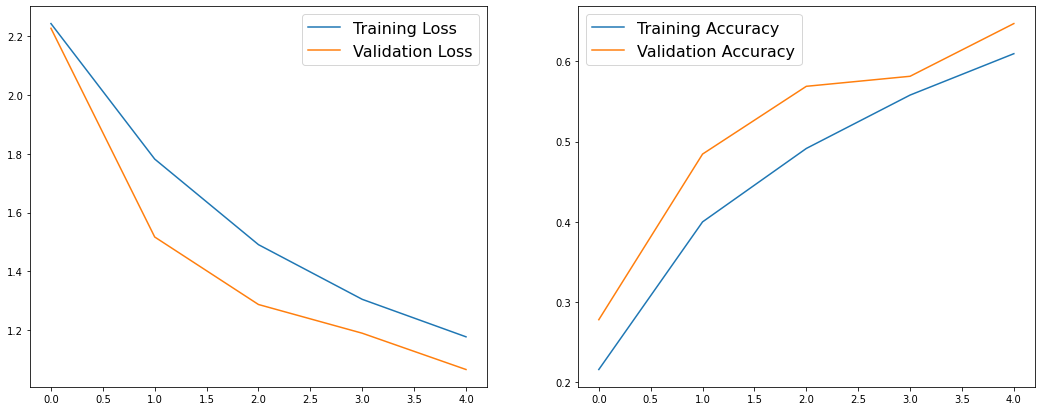

In [9]:
plot_learning_curves(history_simple_att['train_history'])

2021-08-27 23:50:39.343533: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2021-08-27 23:50:39.406797: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-27 23:50:39.483812: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-27 23:50:39.73203

Test set accuracy: 55.135%


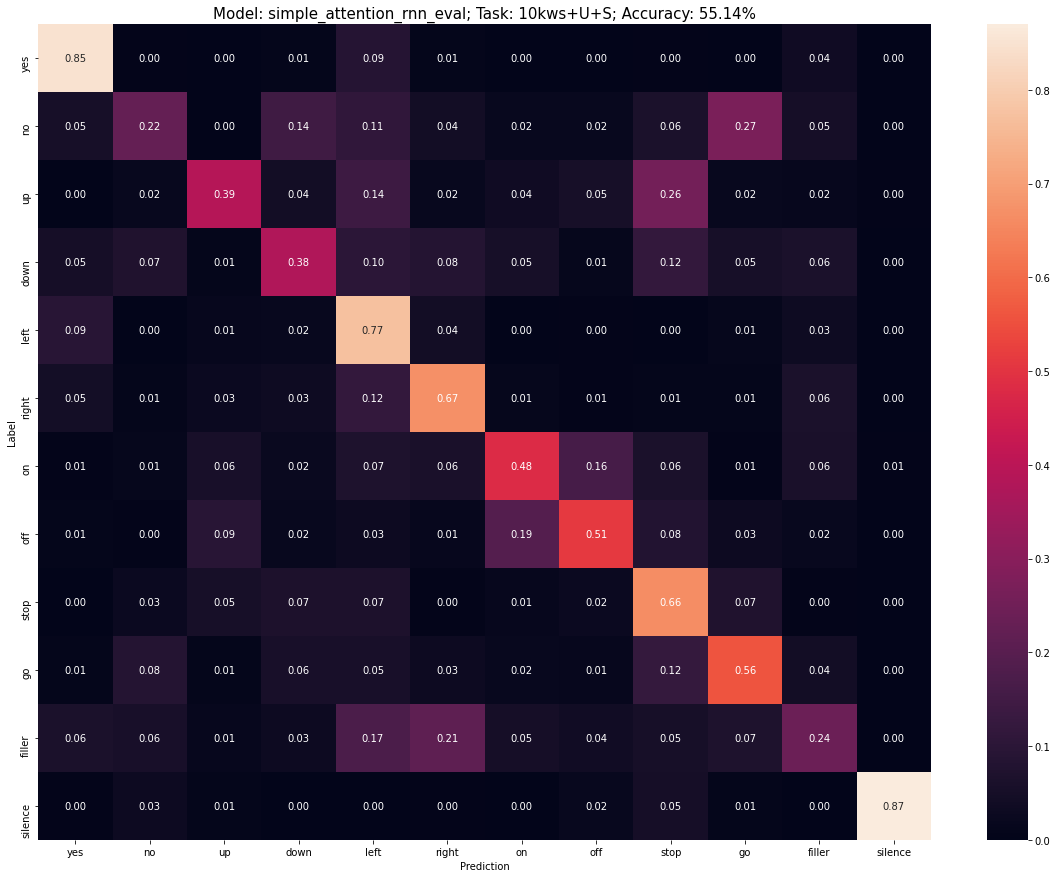

In [10]:
y_scores, att_scores, test_acc = make_confmatrix(model_simple_att, test_dataset)

In [11]:
#update results
results_12kws_task = update_results(results_12kws_task, 
                                    model_simple_att, 
                                    "SimpleAttModel", 
                                    y_scores, 
                                    att_scores, 
                                    test_acc)

## De Andreade Attention model

In [12]:
model_att_andreade = attention_rnn_andreade(train_dataset, output_classes, "test_train", mfccs=True)
model_att_andreade.summary()

Input shape: (16000,)


2021-08-27 23:50:41.766832: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model: "andreade_original_test_train"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment_1 (RandomN (None, 16000)        0           input_2[0][0]                    
__________________________________________________________________________________________________
mfcc_1 (MFCC)                   (None, 98, 40, 1)    0           random_noise_augment_1[0][0]     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 98, 40, 1)    4           mfcc_1[0][0]                     
_______________________________________________________________________

In [13]:
model_att_andreade.load_weights(f"models/{current_task}/andreade_original_mfccs/weights").expect_partial()
with (open(f"models/{current_task}/andreade_original_mfccs/train_history.pkl", "rb")) as openfile:
    history_andreade = pickle.load(openfile)

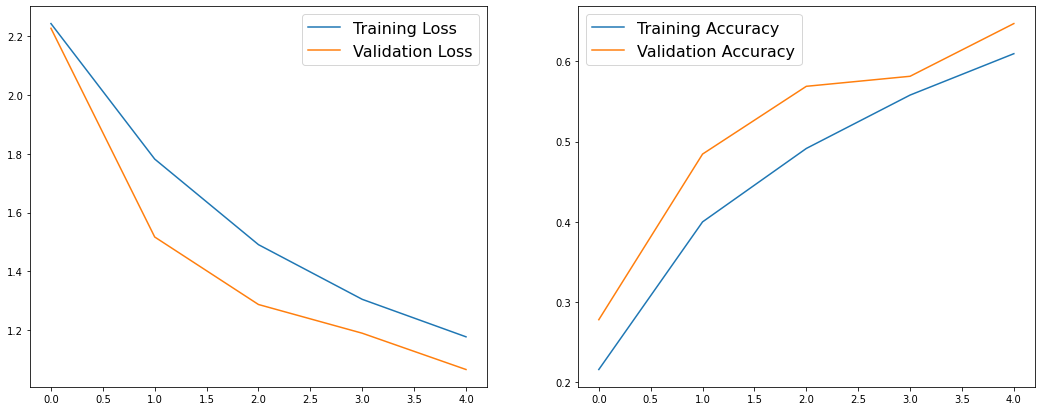

In [14]:
plot_learning_curves(history_andreade['train_history'])

2021-08-27 23:50:44.370196: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 62.275%


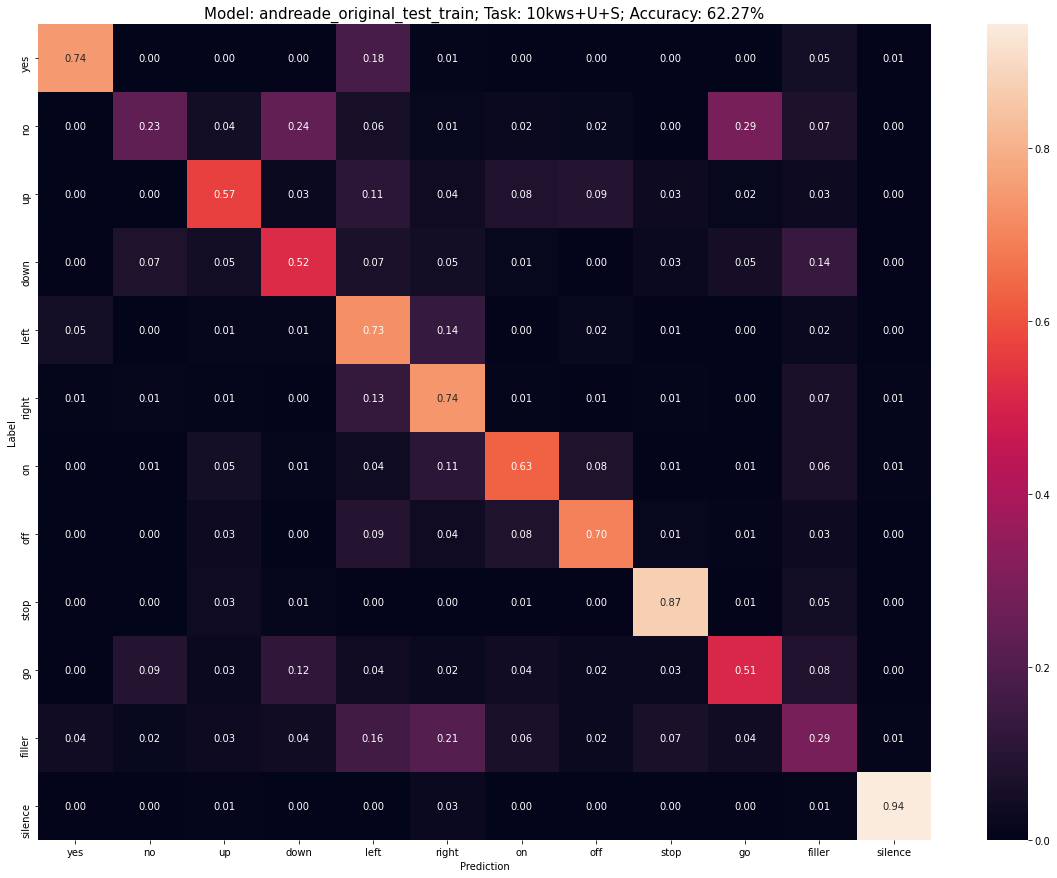

In [15]:
y_scores, att_scores, test_acc = make_confmatrix(model_att_andreade, test_dataset)

In [16]:
results_12kws_task = update_results(results_12kws_task, 
                                    model_att_andreade, 
                                    "AndreadeOriginal", 
                                    y_scores, 
                                    att_scores, 
                                    test_acc)

## De Andreade Attention model - seq query

In [17]:
andreade_seq_query = attention_rnn_andreade_seq_query(train_dataset, output_classes, "test_train", mfccs=True)
andreade_seq_query.summary()

Input shape: (16000,)


2021-08-27 23:50:46.532641: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model: "andreade_seq_query_test_train"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment_2 (RandomN (None, 16000)        0           input_3[0][0]                    
__________________________________________________________________________________________________
mfcc_2 (MFCC)                   (None, 98, 40, 1)    0           random_noise_augment_2[0][0]     
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 98, 40, 1)    4           mfcc_2[0][0]                     
______________________________________________________________________

In [18]:
andreade_seq_query.load_weights(f"models/{current_task}/andreade_seq_query_mfccs/weights").expect_partial()
with (open(f"models/{current_task}/andreade_seq_query_mfccs/train_history.pkl", "rb")) as openfile:
    history_seq_query = pickle.load(openfile)

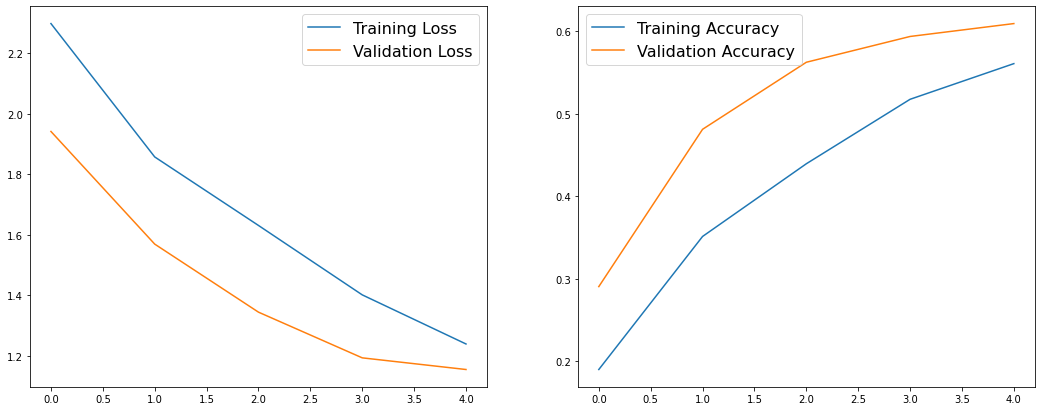

In [19]:
plot_learning_curves(history_seq_query['train_history'])

2021-08-27 23:50:48.857705: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 60.822%


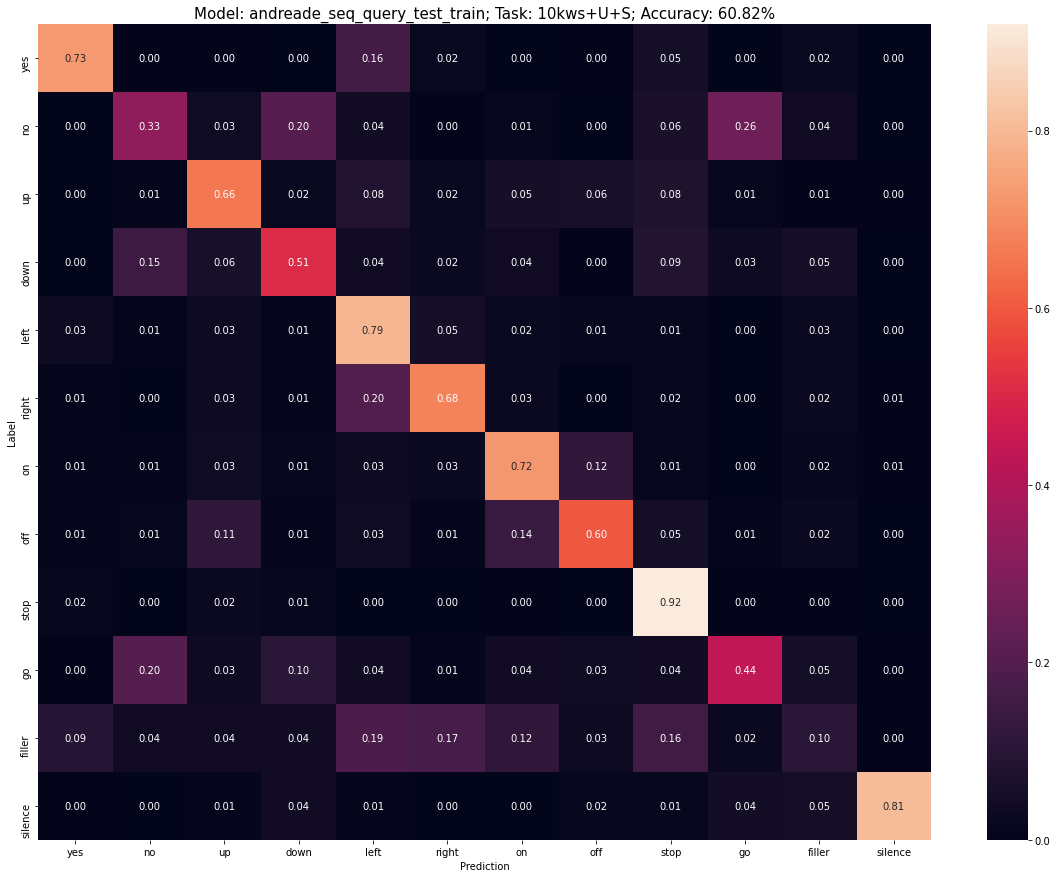

In [20]:
y_scores, att_scores, test_acc = make_confmatrix(andreade_seq_query, test_dataset)

In [21]:
results_12kws_task = update_results(results_12kws_task, 
                                    andreade_seq_query, 
                                    "AndreadeSeqQuery", 
                                    y_scores, 
                                    att_scores, 
                                    test_acc)

## Seq Query, no CNN

In [22]:
seq_query_no_cnn = andreade_seq_query_no_cnn(train_dataset, output_classes, "test_train", mfccs=True)
seq_query_no_cnn.summary()
seq_query_no_cnn.load_weights(f"models/{current_task}/andreade_seq_query_no_CNN_mfccs/weights").expect_partial()
with (open(f"models/{current_task}/andreade_seq_query_no_CNN_mfccs/train_history.pkl", "rb")) as openfile:
    history_seq_query_no_cnn = pickle.load(openfile)

Input shape: (16000,)


2021-08-27 23:50:51.066947: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model: "andreade_seq_query_no_CNN_test_train"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment_3 (RandomN (None, 16000)        0           input_4[0][0]                    
__________________________________________________________________________________________________
mfcc_3 (MFCC)                   (None, 98, 40, 1)    0           random_noise_augment_3[0][0]     
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 98, 40, 1)    4           mfcc_3[0][0]                     
_______________________________________________________________

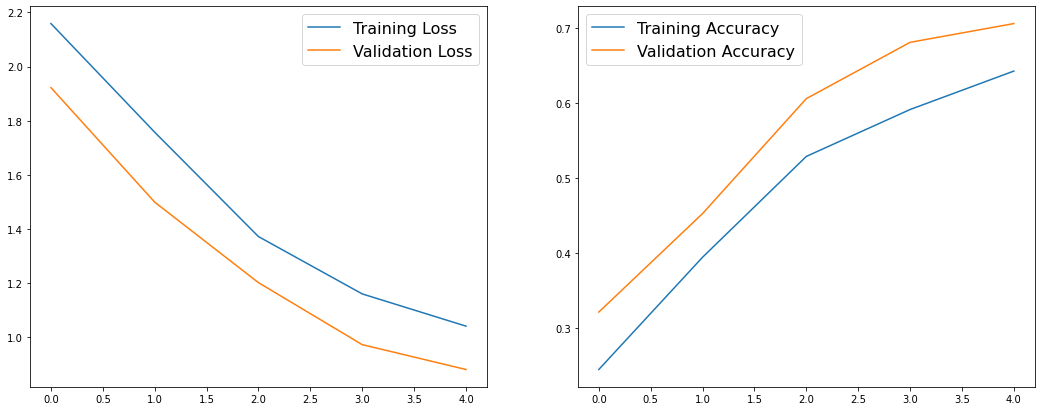

In [23]:
plot_learning_curves(history_seq_query_no_cnn['train_history'])

2021-08-27 23:50:53.808299: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 70.949%


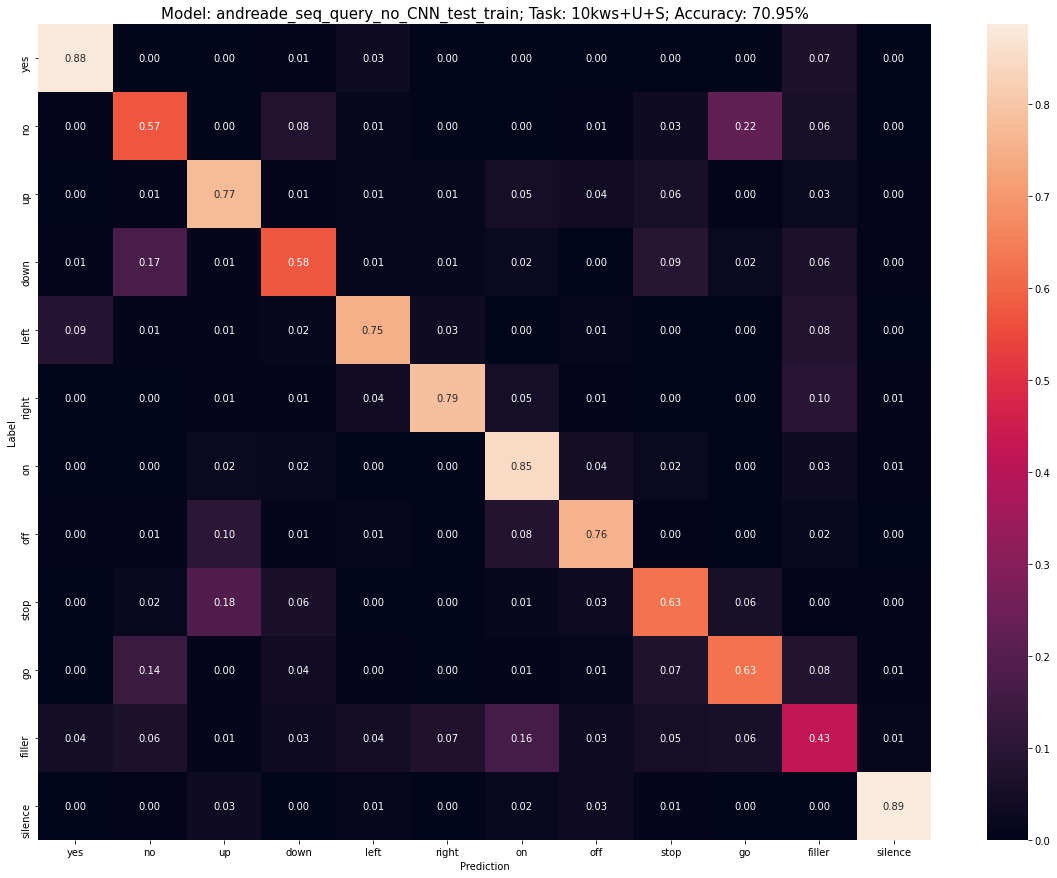

In [24]:
y_scores, att_scores, test_acc = make_confmatrix(seq_query_no_cnn, test_dataset)

In [25]:
results_12kws_task = update_results(results_12kws_task, 
                                    seq_query_no_cnn, 
                                    "SeqQueryNoCNN", 
                                    y_scores, 
                                    att_scores, 
                                    test_acc)

## MHAtt-RNN

Input shape: (16000,)


2021-08-27 23:50:56.229635: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


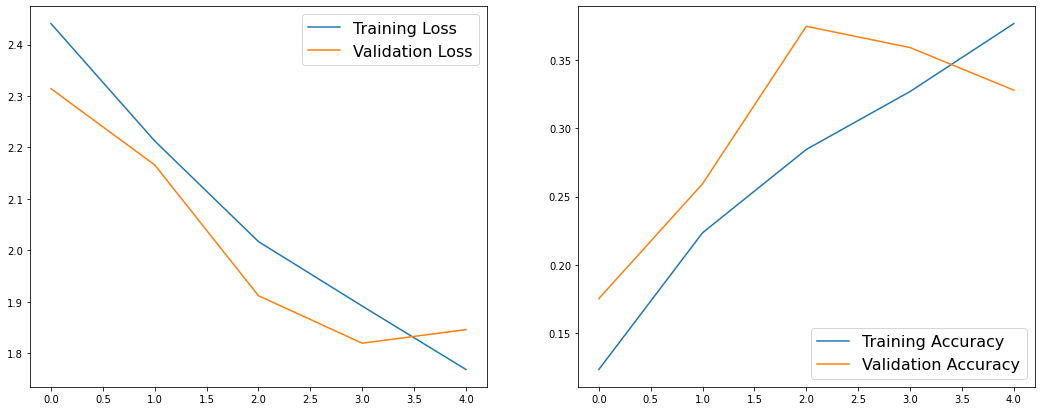

Test set accuracy: 35.986%


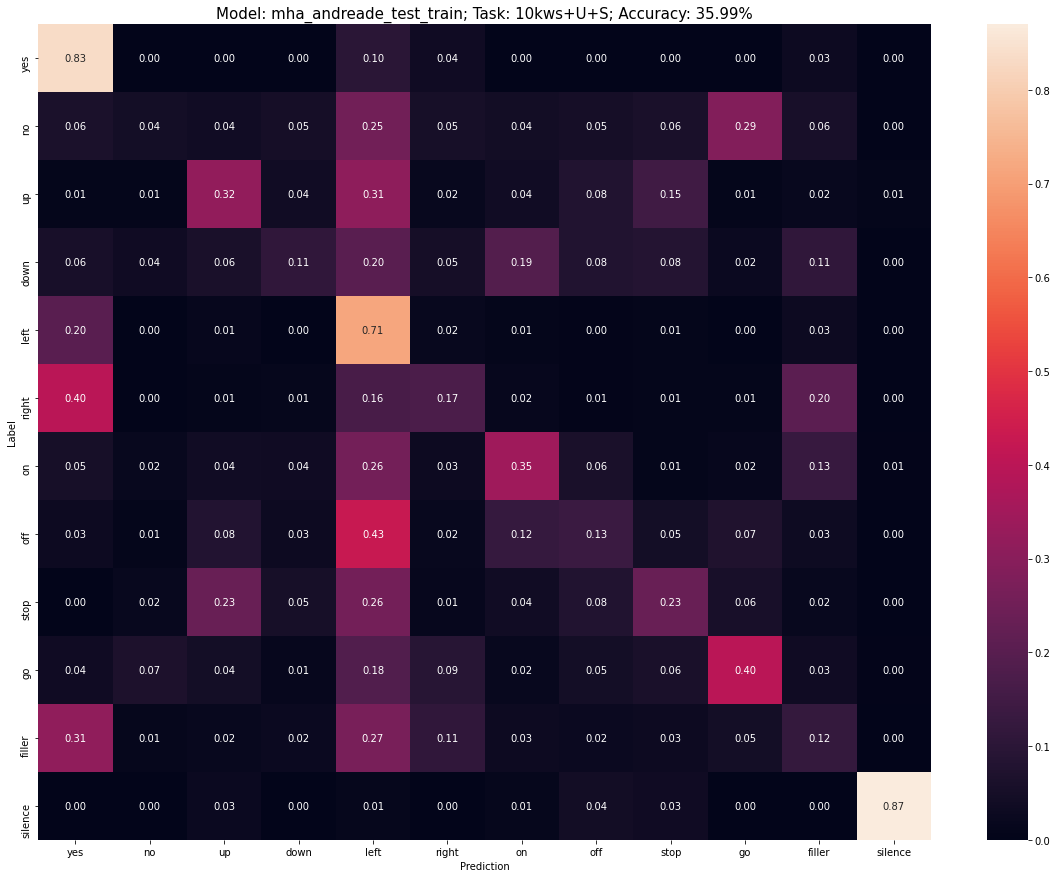

Input shape: (16000,)


2021-08-27 23:51:00.049489: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


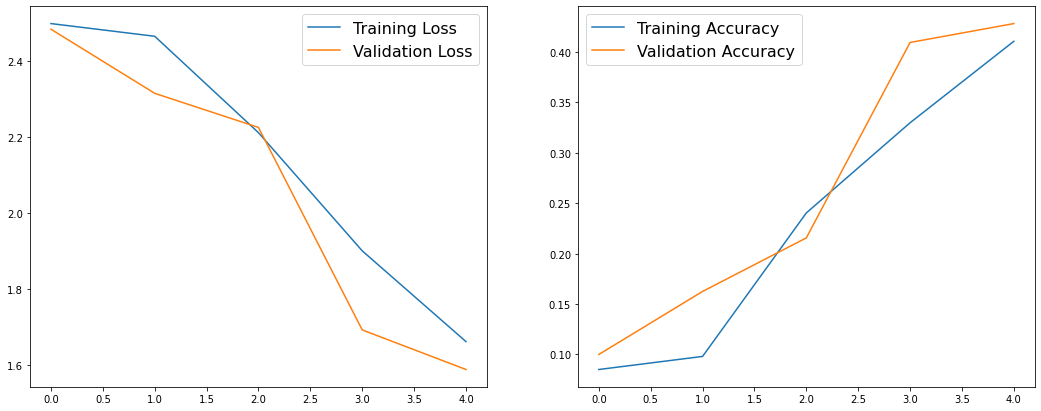

Test set accuracy: 45.949%


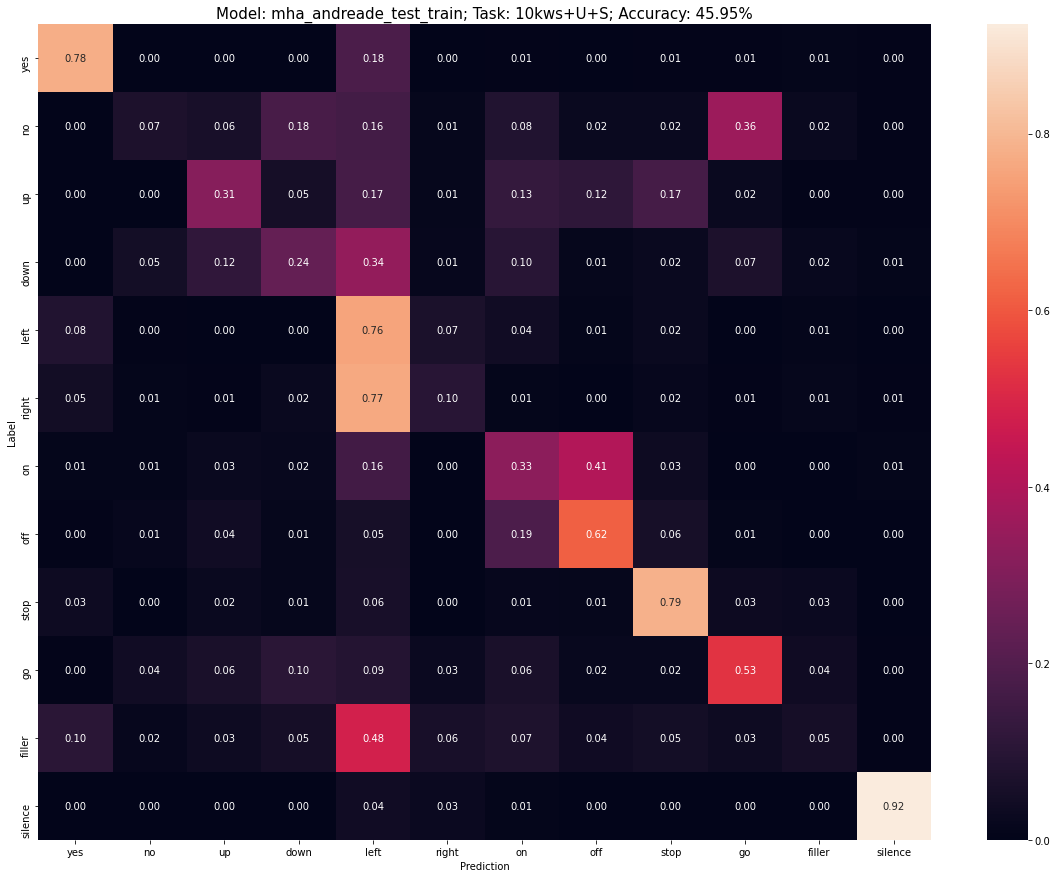

Input shape: (16000,)


2021-08-27 23:51:04.101774: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


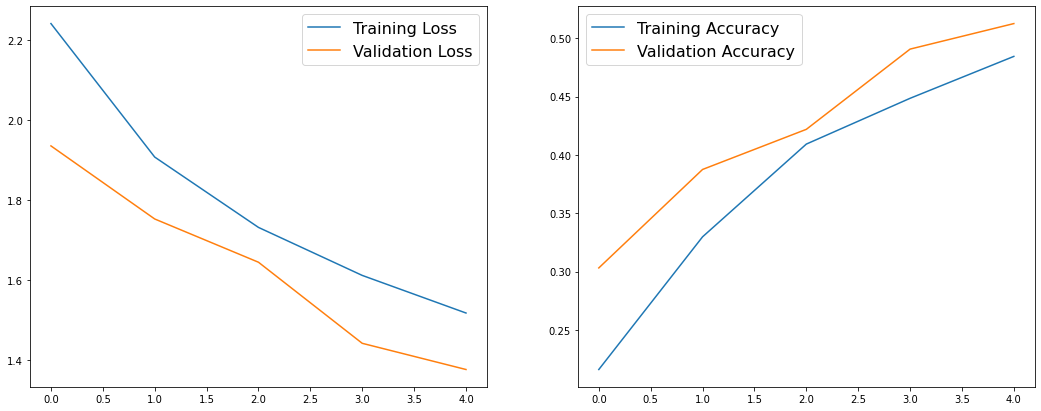

Test set accuracy: 52.864%


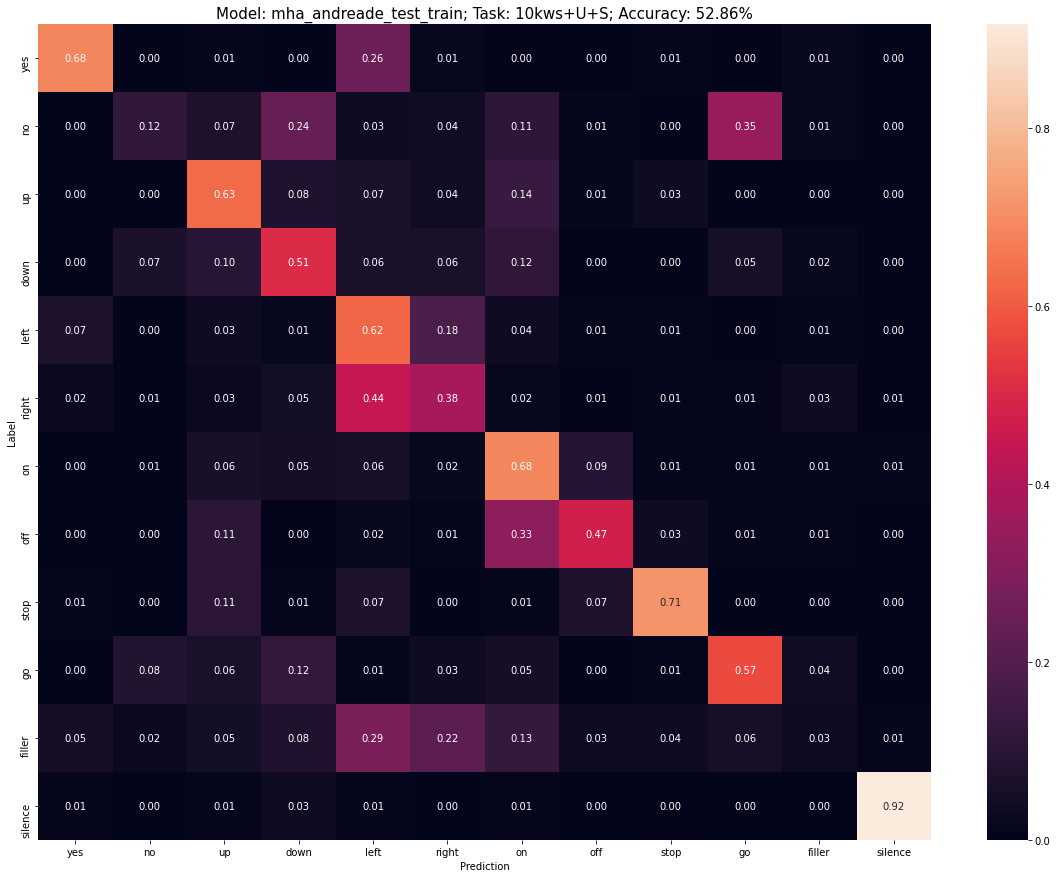

Input shape: (16000,)


2021-08-27 23:51:07.904108: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


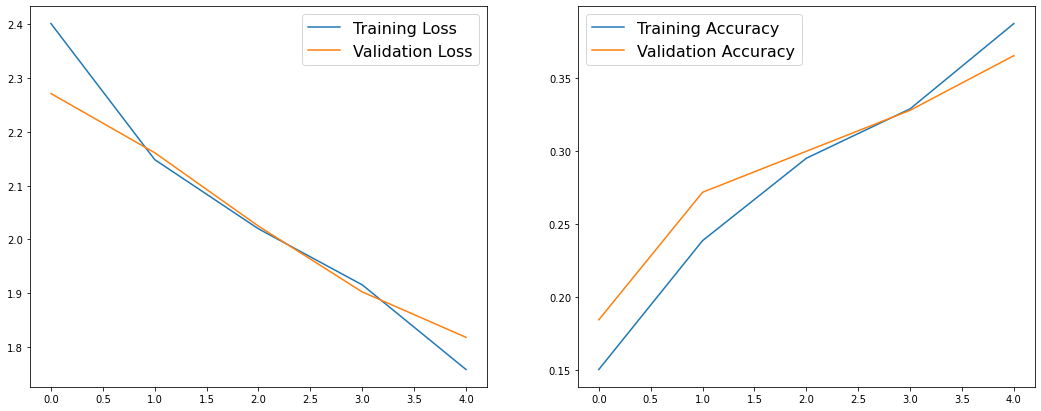

Test set accuracy: 36.620%


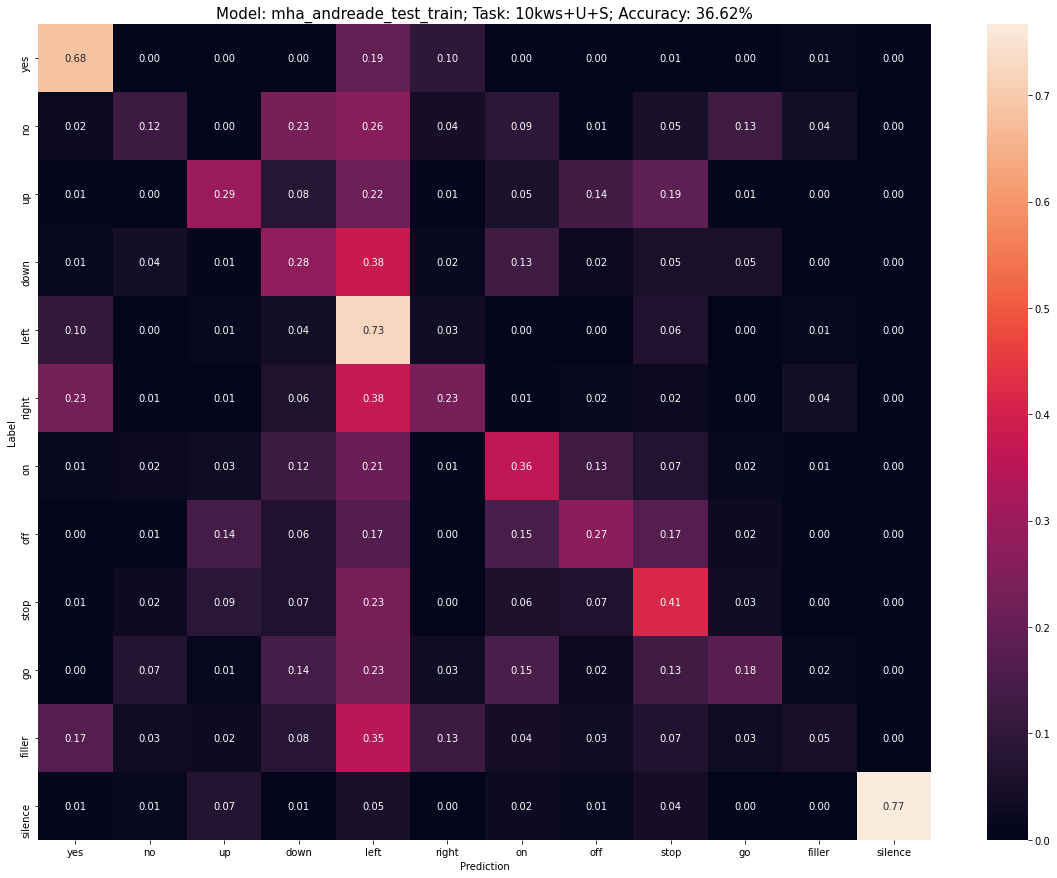

In [26]:
for n_heads in [2,3,4,5]:
    current_mha_model = mha_andreade(train_dataset, output_classes, "test_train", mfccs=True, n_heads=n_heads)
    current_mha_model.load_weights(f"models/{current_task}/mha_andreade_mfccs_{n_heads}heads/weights").expect_partial()
    with (open(f"models/{current_task}/mha_andreade_mfccs_{n_heads}heads/train_history.pkl", "rb")) as openfile:
        history_current_mha_model = pickle.load(openfile)
    plot_learning_curves(history_current_mha_model['train_history'])
    y_scores, att_scores, test_acc = make_confmatrix(current_mha_model, test_dataset)
    results_12kws_task = update_results(results_12kws_task, 
                                    current_mha_model, 
                                    f"MHattRNN_{n_heads}heads", 
                                    y_scores, 
                                    att_scores, 
                                    test_acc)

## ResnetAttention

Input shape: (16000,)


2021-08-27 23:51:22.067078: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


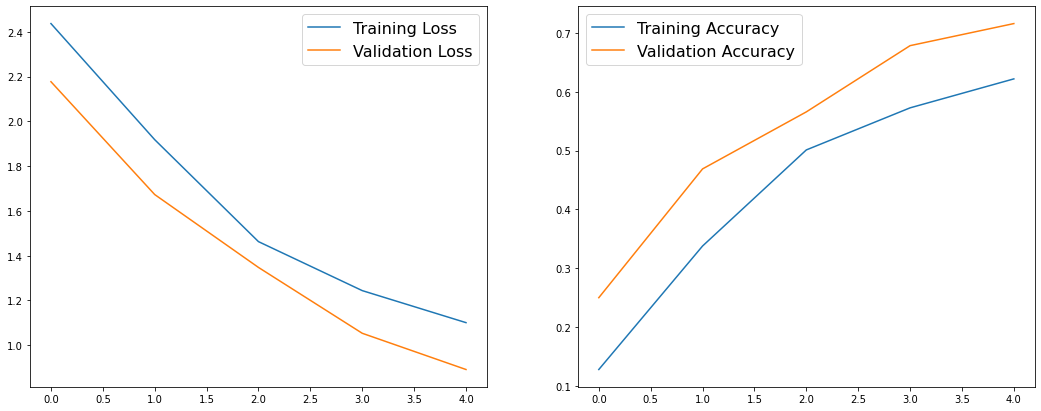

2021-08-27 23:51:24.716588: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 66.980%


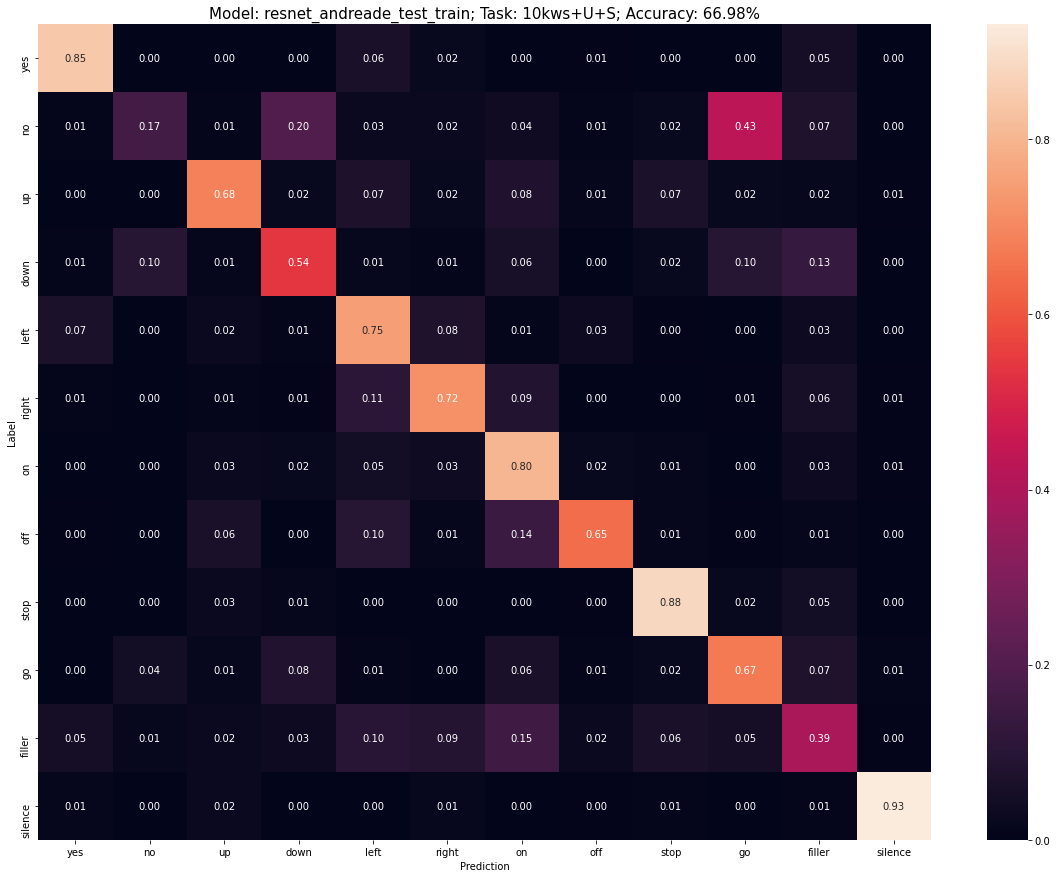

Input shape: (16000,)


2021-08-27 23:51:26.815664: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


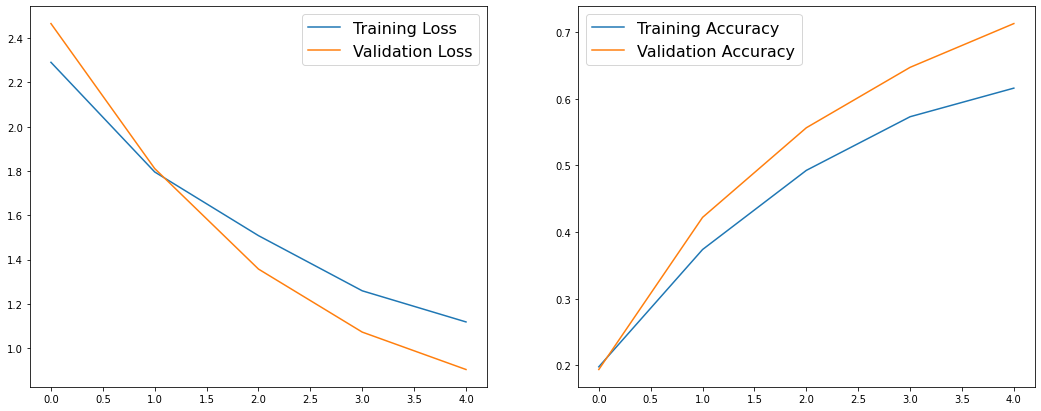

2021-08-27 23:51:29.537196: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 67.267%


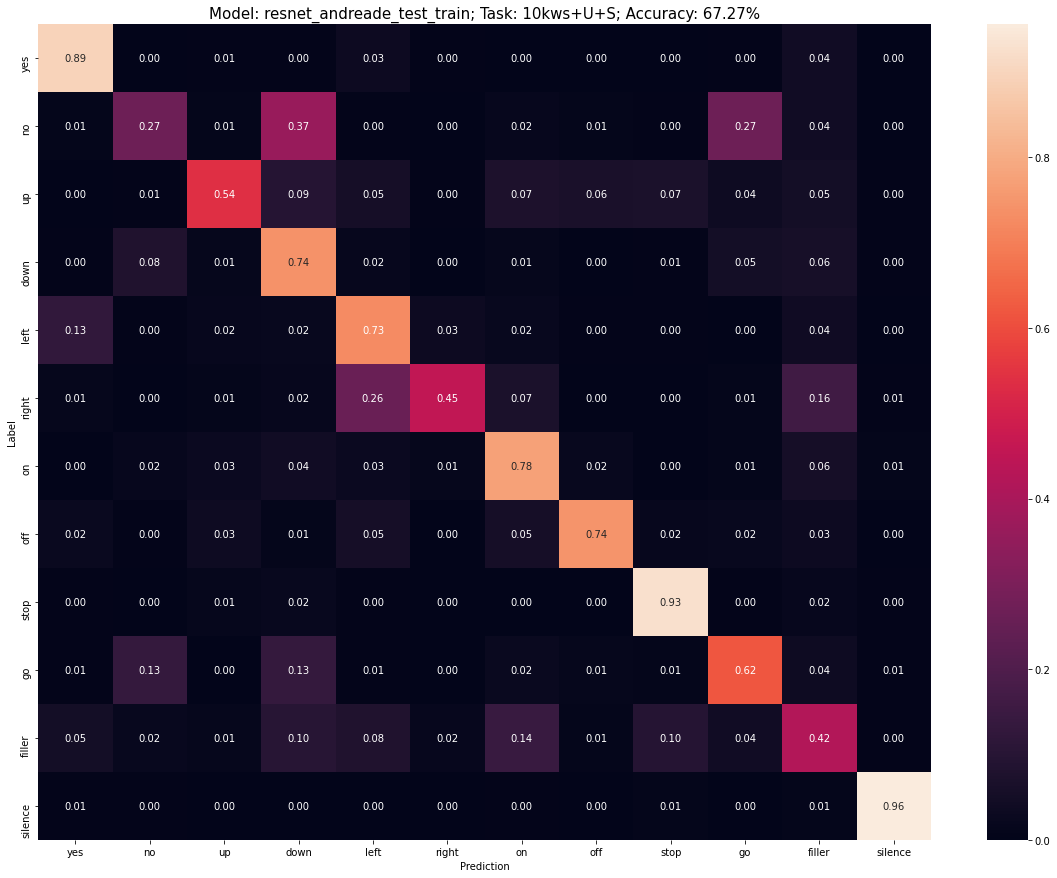

Input shape: (16000,)


2021-08-27 23:51:31.679148: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


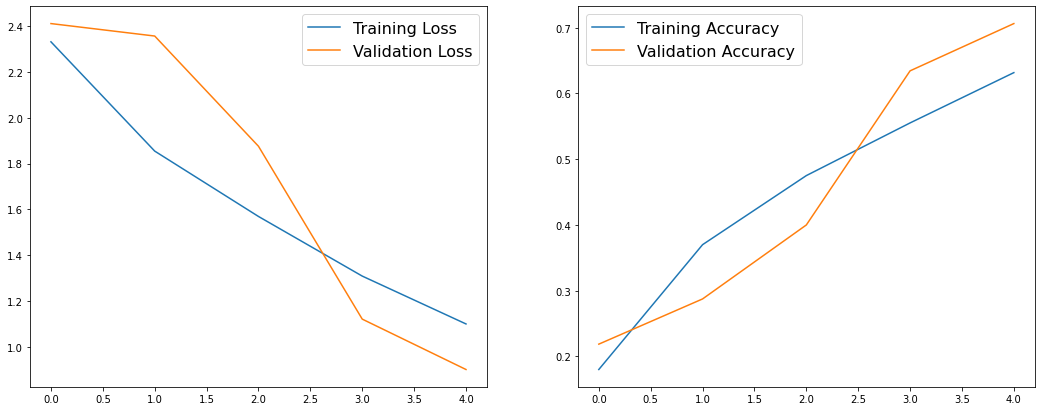

2021-08-27 23:51:34.763796: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 68.412%


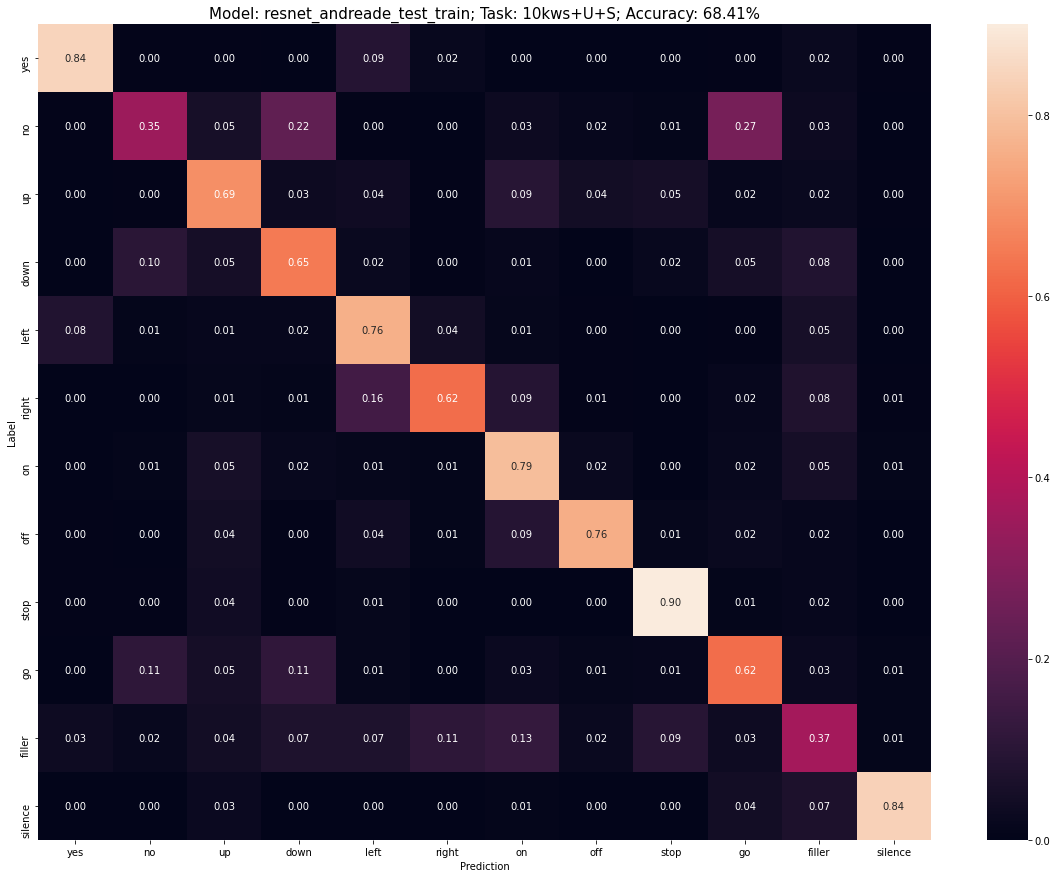

In [28]:
for n_layers in [3,4,5]:
    current_resnet_model = resnet_andreade(train_dataset, output_classes, "test_train", mfccs=True, n_res_blocks=n_layers)
    current_resnet_model.load_weights(f"models/{current_task}/resnet_andreade_mfccs_{n_layers}_layers/weights").expect_partial()
    
    with (open(f"models/{current_task}/resnet_andreade_mfccs_{n_layers}_layers/train_history.pkl", "rb")) as openfile:
        history_current_resnet_model = pickle.load(openfile)
    plot_learning_curves(history_current_resnet_model['train_history'])
    
    y_scores, att_scores, test_acc = make_confmatrix(current_resnet_model, test_dataset)
    results_12kws_task = update_results(results_12kws_task, 
                                    current_resnet_model, 
                                    f"ResAndreade_{n_layers}layers", 
                                    y_scores, 
                                    att_scores, 
                                    test_acc)
    del current_resnet_model

## KWT

In [29]:
## TODO

In [30]:
results_12kws_task.keys()

dict_keys(['SimpleAttModel', 'AndreadeOriginal', 'AndreadeSeqQuery', 'SeqQueryNoCNN', 'MHattRNN_2heads', 'MHattRNN_3heads', 'MHattRNN_4heads', 'MHattRNN_5heads', 'ResAndreade_3layers', 'ResAndreade_4layers', 'ResAndreade_5layers'])

In [31]:
## Save all the results to disk
with open(hyperparams._MODELS_DIR_/current_task/'all_results.pkl', 'wb') as outp:
    pickle.dump(results_12kws_task, outp)

# 2) 35kws task

In [32]:
current_task = hyperparams._TASKS_[1]
print(current_task)
core_kws, aux_kws, output_classes = get_kws(hyperparams._DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)

if len(os.listdir(hyperparams._BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    make_and_save_original_splits(current_task, return_canonical_test_set=False)

X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task, smoke_size=-1)

batch_size = 64
train_dataset, train_steps, valid_dataset, valid_steps, test_dataset = get_tf_datasets(X_train, 
                             y_train, 
                             X_valid, 
                             y_valid, 
                             X_test, 
                             y_test, 
                             batch_size=batch_size,
                            task=current_task)

# just iterate one time on the test set in order to create the cache file
for i in iter(test_dataset):
    pass

35kws
Core keywords:  ['off', 'three', 'happy', 'eight', 'up', 'no', 'seven', 'marvin', 'five', 'cat', 'visual', 'forward', 'right', 'wow', 'zero', 'learn', 'bird', 'left', 'nine', 'house', 'dog', 'backward', 'on', 'two', 'sheila', 'follow', 'tree', 'yes', 'four', 'one', 'stop', 'six', 'down', 'go', 'bed']

Auxiliary keywords:  []

Output Classes:  ['off', 'three', 'happy', 'eight', 'up', 'no', 'seven', 'marvin', 'five', 'cat', 'visual', 'forward', 'right', 'wow', 'zero', 'learn', 'bird', 'left', 'nine', 'house', 'dog', 'backward', 'on', 'two', 'sheila', 'follow', 'tree', 'yes', 'four', 'one', 'stop', 'six', 'down', 'go', 'bed']
Train steps: 1326
Validations steps: 156
Example of dataset element:
(<tf.Tensor: shape=(64, 16000), dtype=float32, numpy=
array([[ 3.1674278e-04, -3.2394113e-05,  6.8747572e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
    

2021-08-27 23:51:38.677597: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Simple Attention RNN

In [33]:
model_simple_att = simple_attention_rnn(train_dataset, output_classes, "eval", mfccs=True)
model_simple_att.summary()

model_simple_att.load_weights(f"models/{current_task}/simple_attention_rnn_mfccs/weights").expect_partial()
with (open("models/10kws+U+S/andreade_original_mfccs/train_history.pkl", "rb")) as openfile:
    history_simple_att = pickle.load(openfile)

Input shape: (16000,)


2021-08-27 23:51:40.127035: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model: "simple_attention_rnn_eval"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment_11 (Random (None, 16000)        0           input_12[0][0]                   
__________________________________________________________________________________________________
mfcc_11 (MFCC)                  (None, 98, 40, 1)    0           random_noise_augment_11[0][0]    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 98, 40, 1)    4           mfcc_11[0][0]                    
__________________________________________________________________________

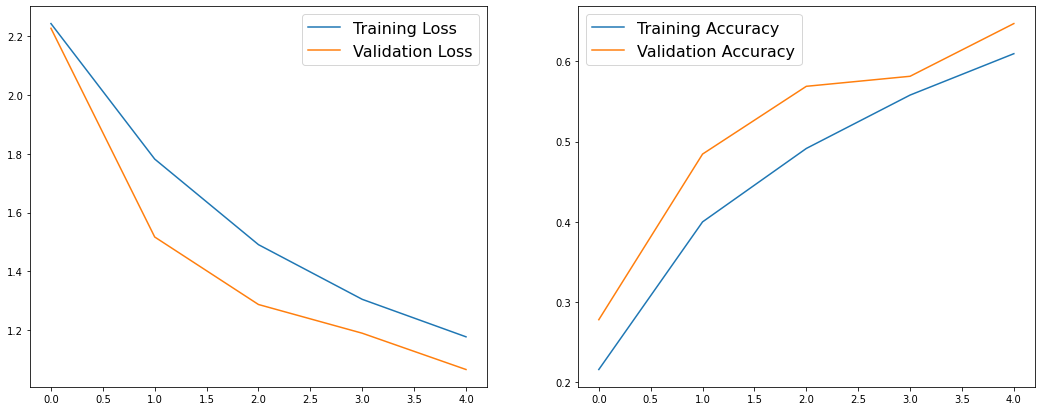

In [34]:
plot_learning_curves(history_simple_att['train_history'])

2021-08-27 23:51:41.675470: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 43.253%


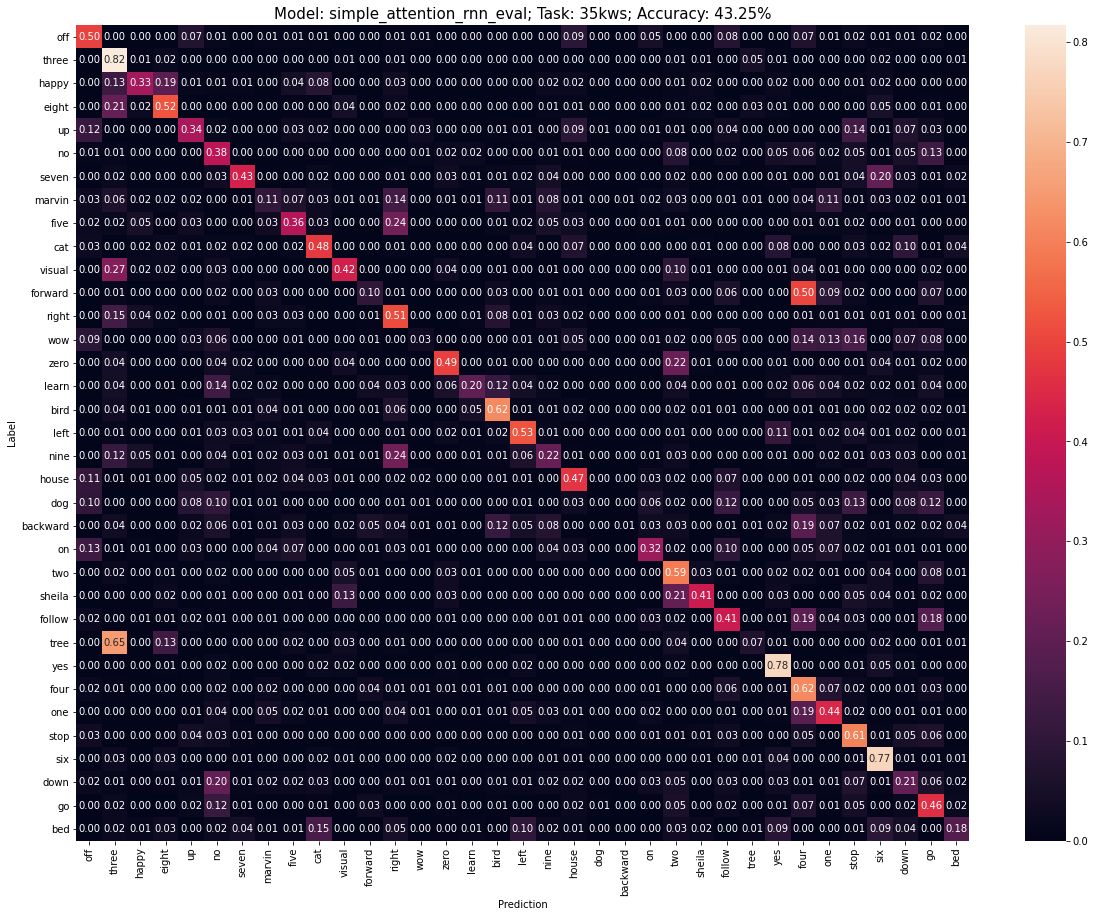

In [35]:
y_scores, att_scores, test_acc = make_confmatrix(model_simple_att, test_dataset)

#update results
results_35kws_task = update_results(results_35kws_task, 
                                    model_simple_att, 
                                    "SimpleAttModel", 
                                    y_scores, 
                                    att_scores, 
                                    test_acc)

## De Andreade Attention model


In [36]:
model_att_andreade = attention_rnn_andreade(train_dataset, output_classes, "test_train", mfccs=True)
model_att_andreade.summary()

model_att_andreade.load_weights(f"models/{current_task}/andreade_original_mfccs/weights").expect_partial()
with (open(f"models/{current_task}/andreade_original_mfccs/train_history.pkl", "rb")) as openfile:
    history_andreade = pickle.load(openfile)

Input shape: (16000,)


2021-08-27 23:51:47.359141: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model: "andreade_original_test_train"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment_12 (Random (None, 16000)        0           input_13[0][0]                   
__________________________________________________________________________________________________
mfcc_12 (MFCC)                  (None, 98, 40, 1)    0           random_noise_augment_12[0][0]    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 98, 40, 1)    4           mfcc_12[0][0]                    
_______________________________________________________________________

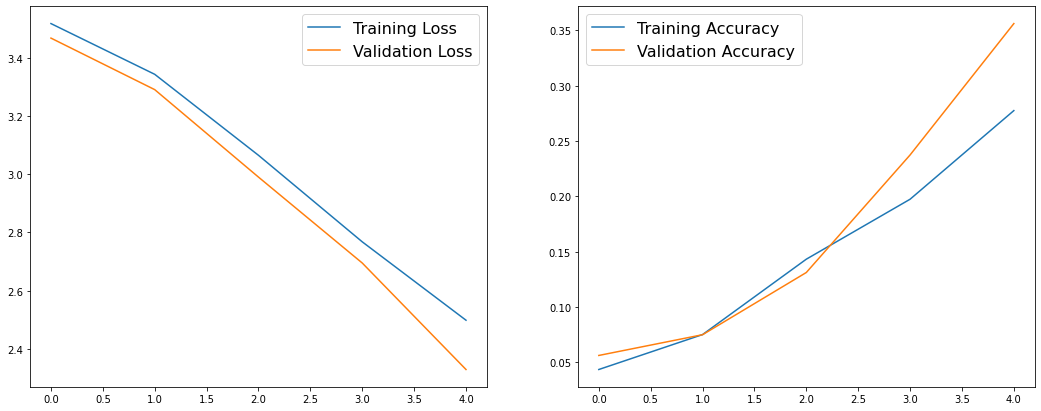

In [37]:
plot_learning_curves(history_andreade['train_history'])

2021-08-27 23:51:49.705394: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 32.921%


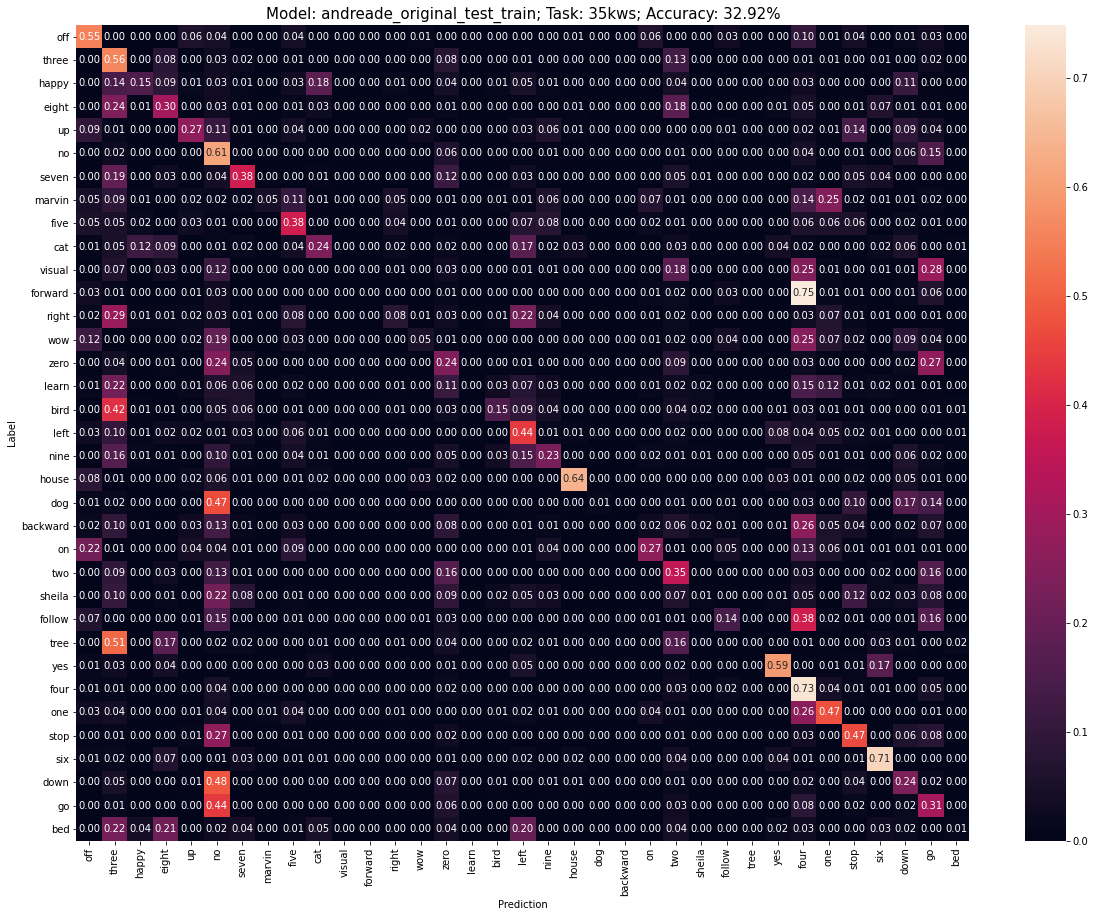

In [38]:
y_scores, att_scores, test_acc = make_confmatrix(model_att_andreade, test_dataset)

results_35kws_task = update_results(results_35kws_task, 
                                    model_att_andreade, 
                                    "AndreadeOriginal", 
                                    y_scores, 
                                    att_scores, 
                                   test_acc)

## De Andreade Attention model - seq query

In [39]:
andreade_seq_query = attention_rnn_andreade_seq_query(train_dataset, output_classes, "test_train", mfccs=True)
andreade_seq_query.summary()

andreade_seq_query.load_weights(f"models/{current_task}/andreade_seq_query_mfccs/weights").expect_partial()
with (open(f"models/{current_task}/andreade_seq_query_mfccs/train_history.pkl", "rb")) as openfile:
    history_seq_query = pickle.load(openfile)

Input shape: (16000,)


2021-08-27 23:51:56.201884: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model: "andreade_seq_query_test_train"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment_13 (Random (None, 16000)        0           input_14[0][0]                   
__________________________________________________________________________________________________
mfcc_13 (MFCC)                  (None, 98, 40, 1)    0           random_noise_augment_13[0][0]    
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 98, 40, 1)    4           mfcc_13[0][0]                    
______________________________________________________________________

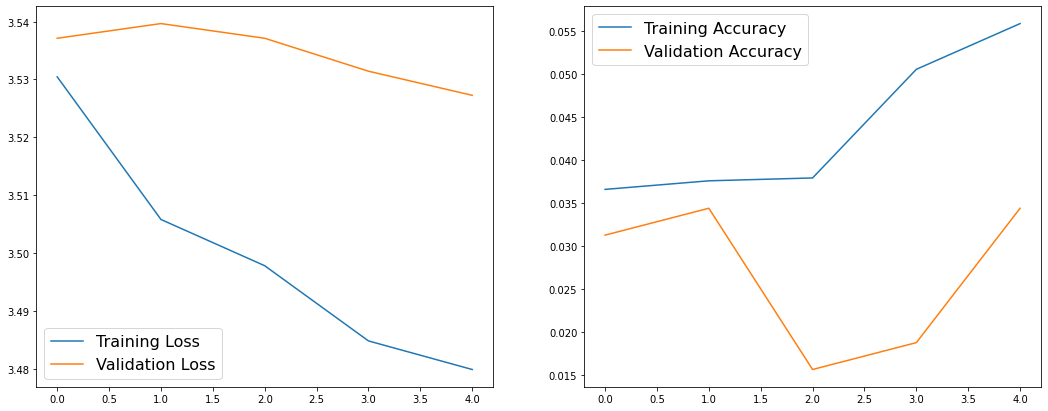

In [40]:
plot_learning_curves(history_seq_query['train_history'])

2021-08-27 23:51:58.458742: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 4.416%


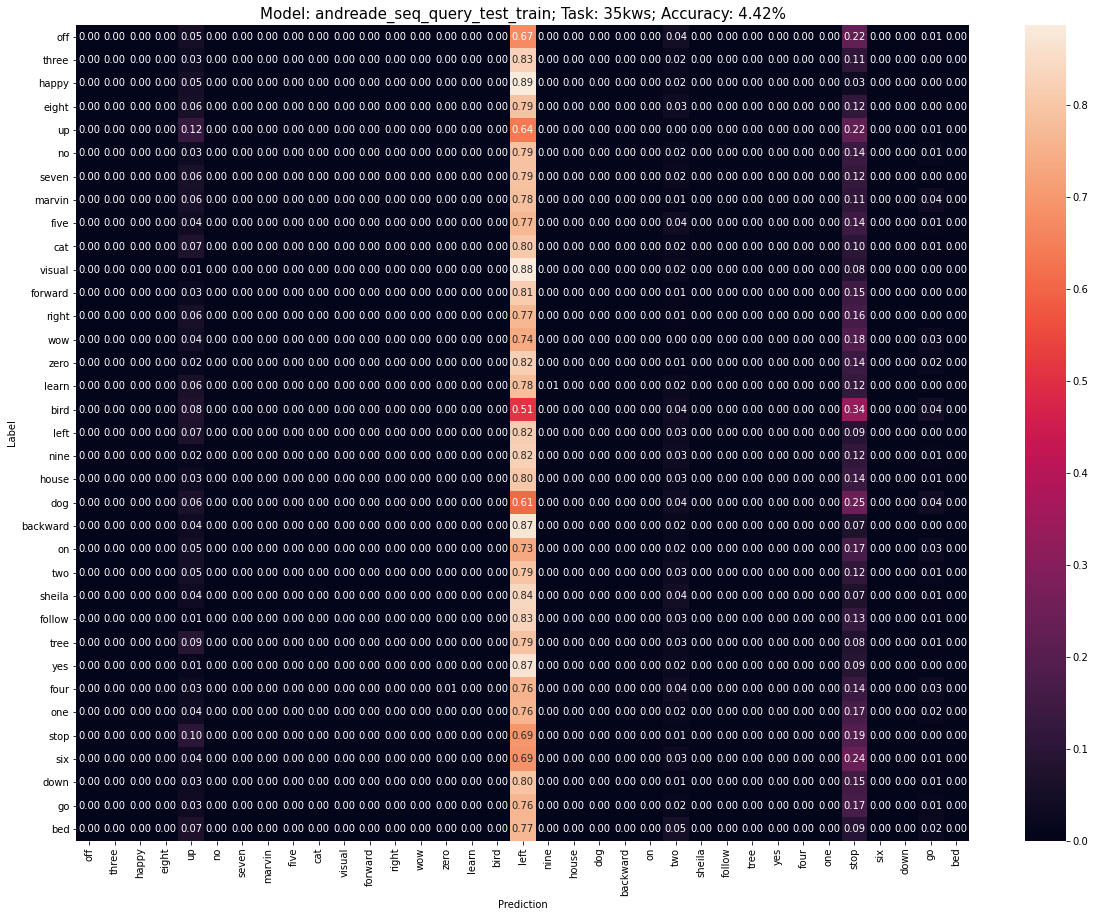

In [41]:
y_scores, att_scores, test_acc = make_confmatrix(andreade_seq_query, test_dataset)

results_35kws_task = update_results(results_35kws_task, 
                                    andreade_seq_query, 
                                    "AndreadeSeqQuery", 
                                    y_scores, 
                                    att_scores, 
                                    test_acc)

## Seq Query, no CNN

In [42]:
seq_query_no_cnn = andreade_seq_query_no_cnn(train_dataset, output_classes, "test_train", mfccs=True)
seq_query_no_cnn.summary()

seq_query_no_cnn.load_weights(f"models/{current_task}/andreade_seq_query_no_CNN_mfccs/weights").expect_partial()
with (open(f"models/{current_task}/andreade_seq_query_no_CNN_mfccs/train_history.pkl", "rb")) as openfile:
    history_seq_query_no_cnn = pickle.load(openfile)

Input shape: (16000,)


2021-08-27 23:52:05.177237: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model: "andreade_seq_query_no_CNN_test_train"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment_14 (Random (None, 16000)        0           input_15[0][0]                   
__________________________________________________________________________________________________
mfcc_14 (MFCC)                  (None, 98, 40, 1)    0           random_noise_augment_14[0][0]    
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 98, 40, 1)    4           mfcc_14[0][0]                    
_______________________________________________________________

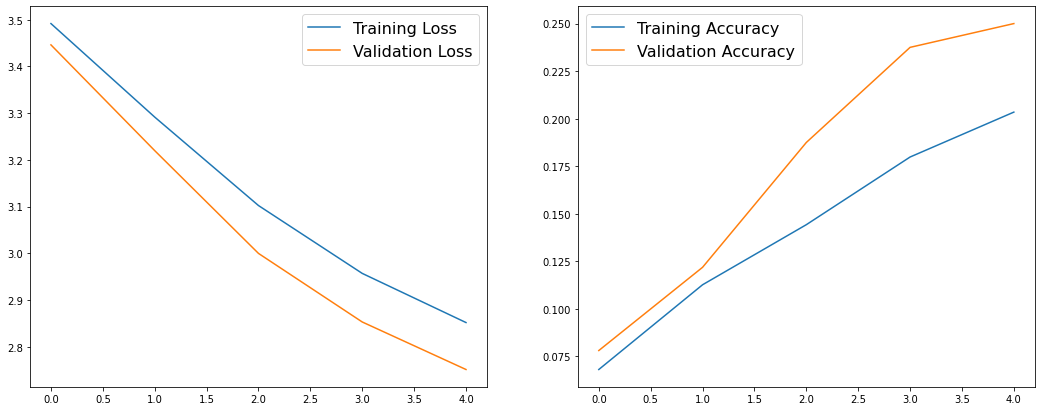

In [43]:
plot_learning_curves(history_seq_query_no_cnn['train_history'])

2021-08-27 23:52:08.070664: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 21.072%


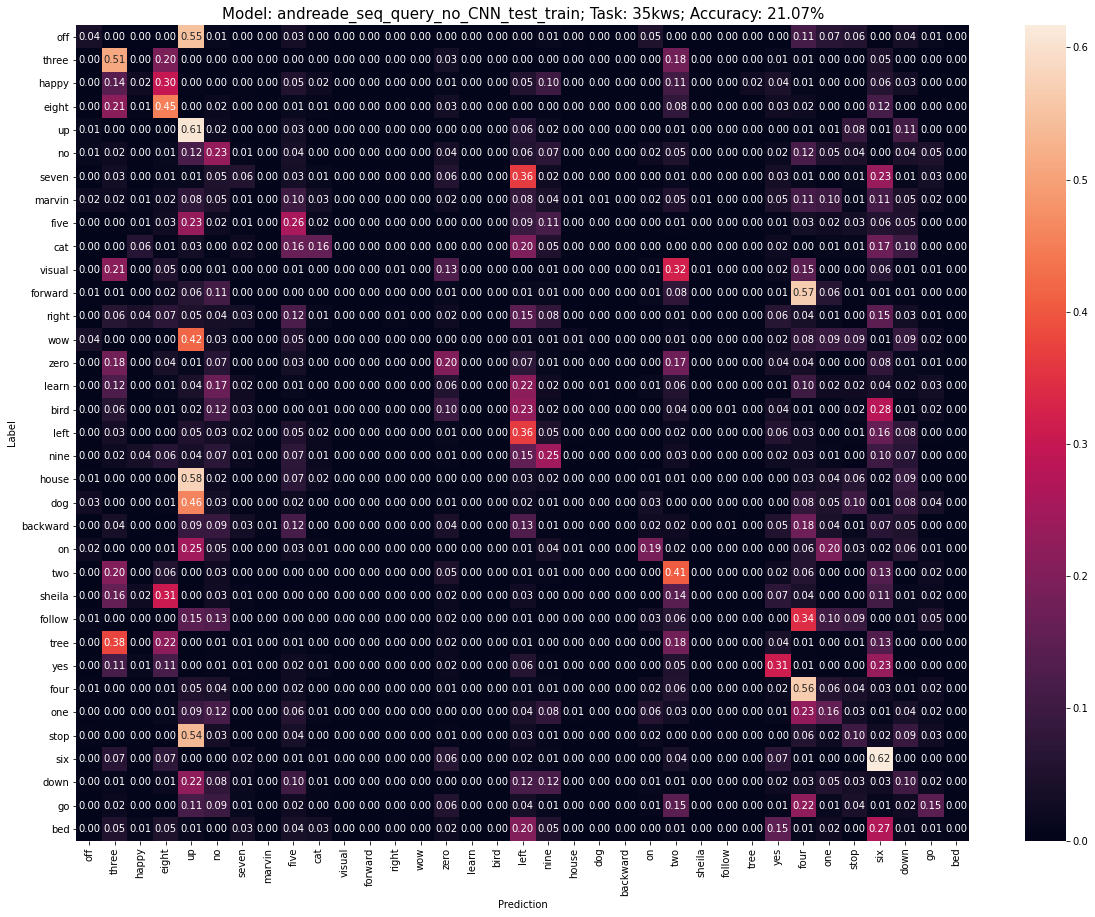

In [44]:
y_scores, att_scores, test_acc = make_confmatrix(seq_query_no_cnn, test_dataset)

results_35kws_task = update_results(results_35kws_task, 
                                    seq_query_no_cnn, 
                                    "SeqQueryNoCNN", 
                                    y_scores, 
                                    att_scores, 
                                    test_acc)


## MHAtt-RNN

Input shape: (16000,)


2021-08-27 23:52:15.029916: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


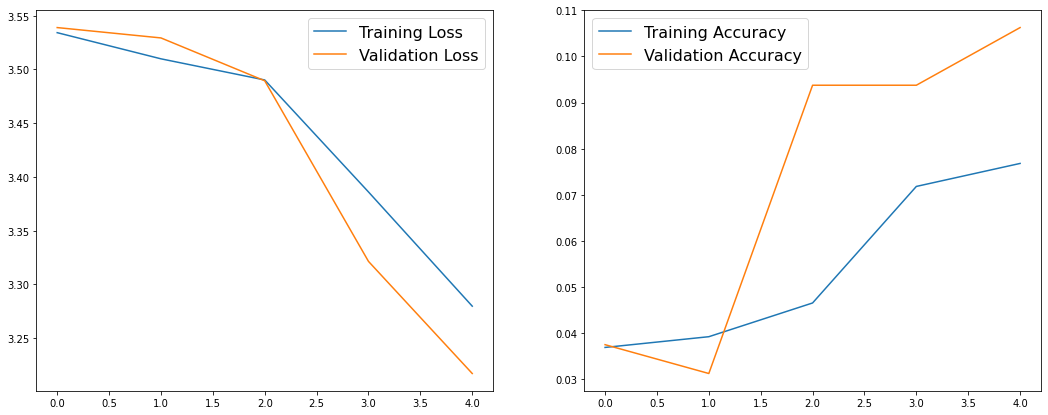

Test set accuracy: 9.478%


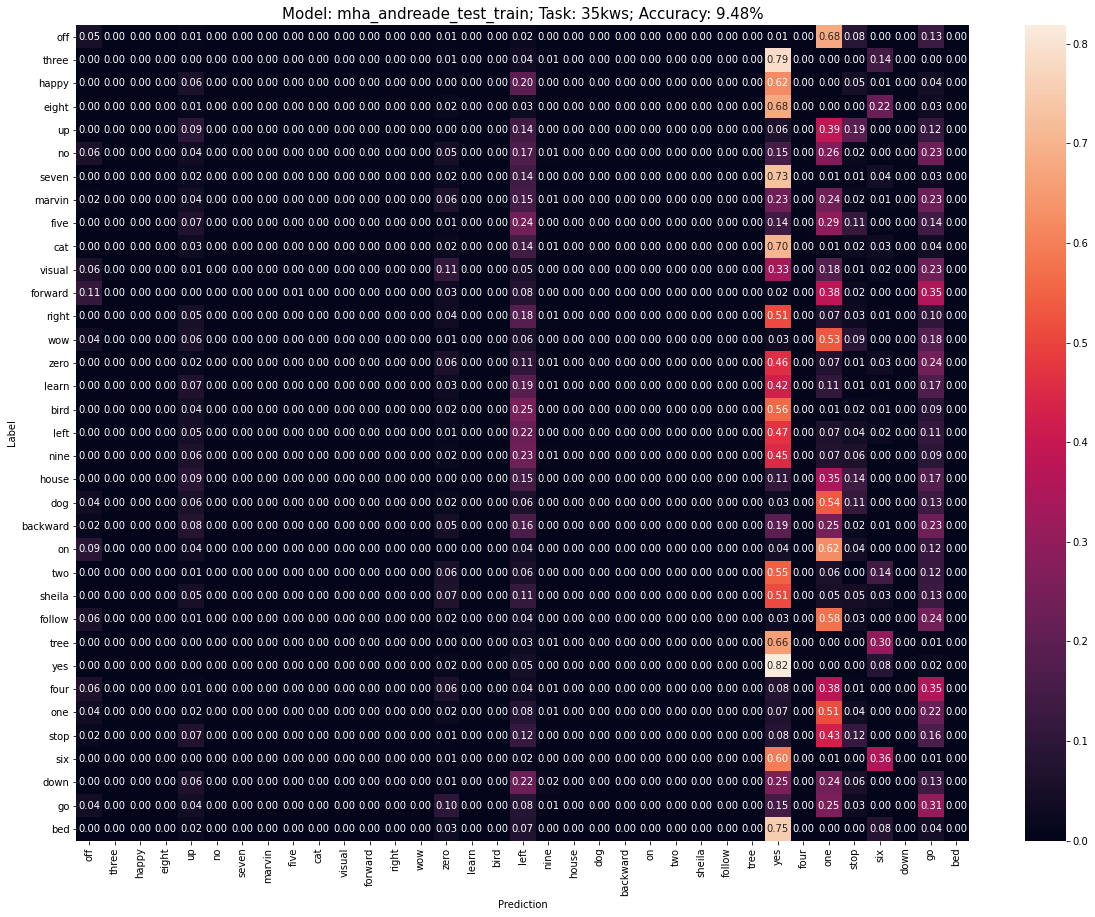

Input shape: (16000,)


2021-08-27 23:52:23.038733: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


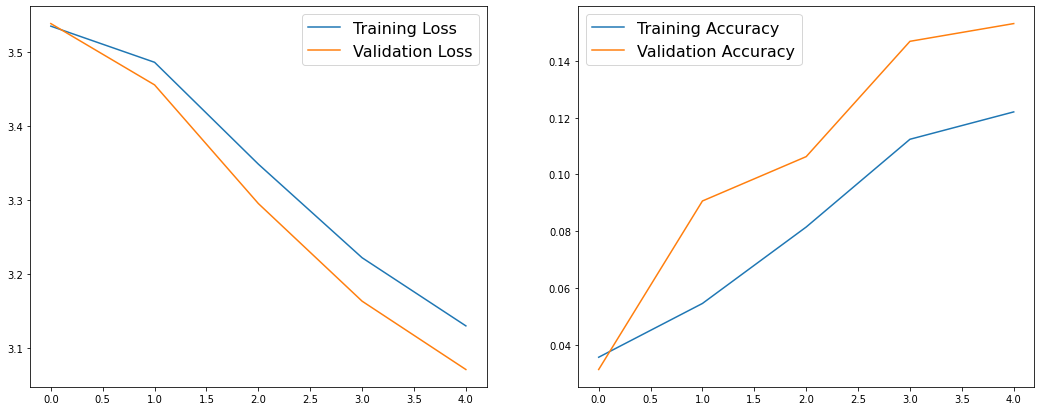

Test set accuracy: 13.712%


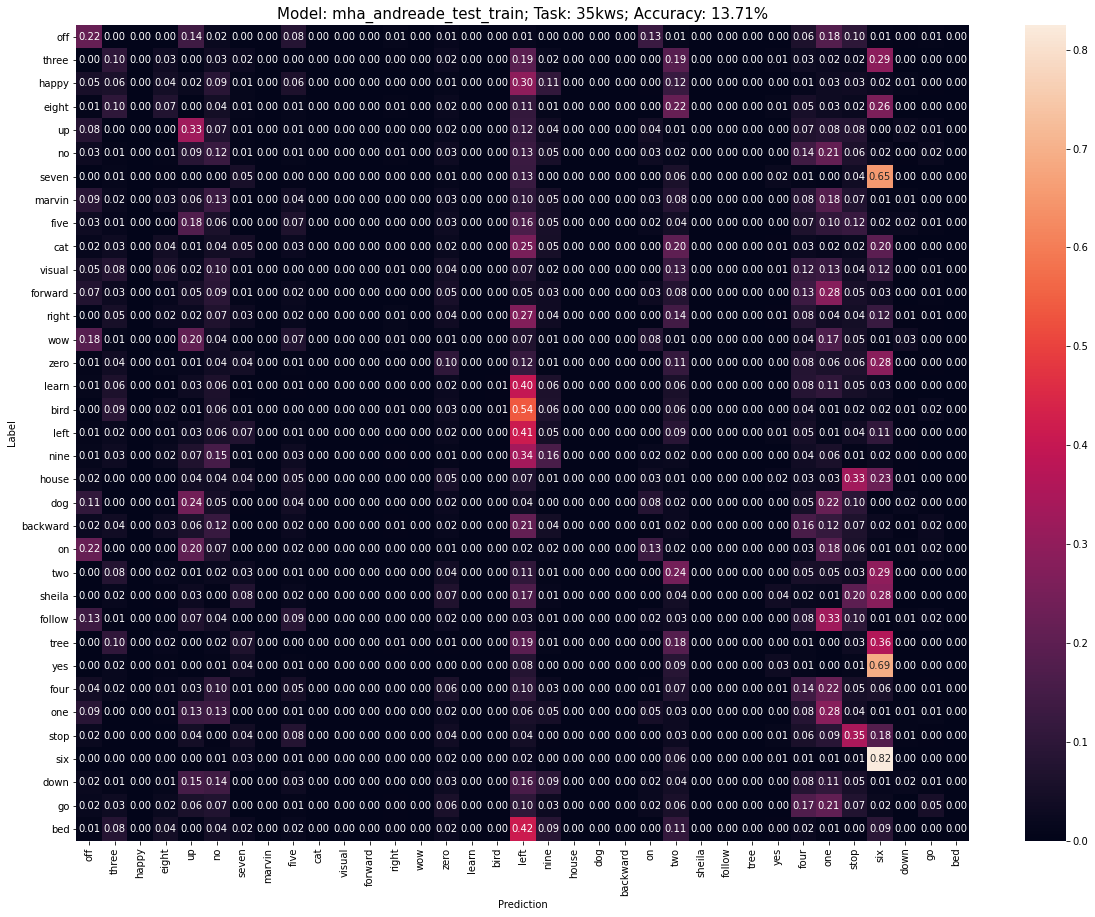

Input shape: (16000,)


2021-08-27 23:52:31.258795: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


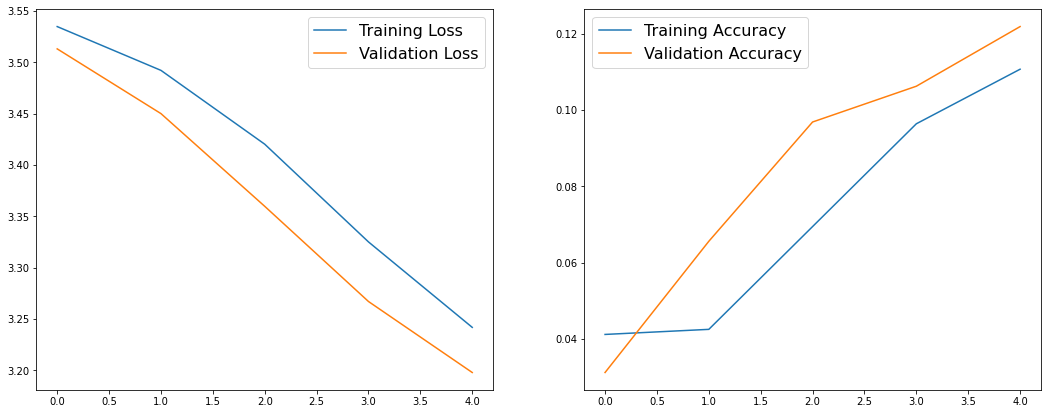

Test set accuracy: 11.876%


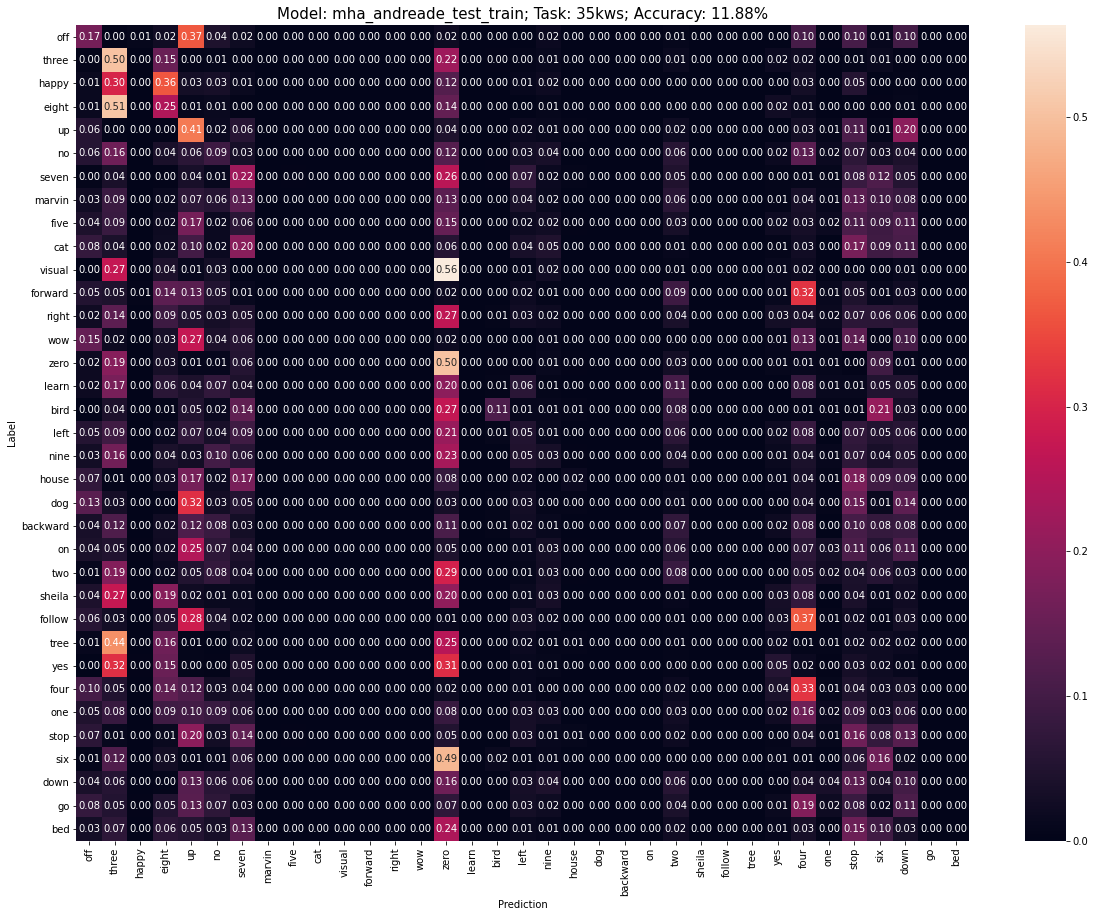

Input shape: (16000,)


2021-08-27 23:52:39.250183: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


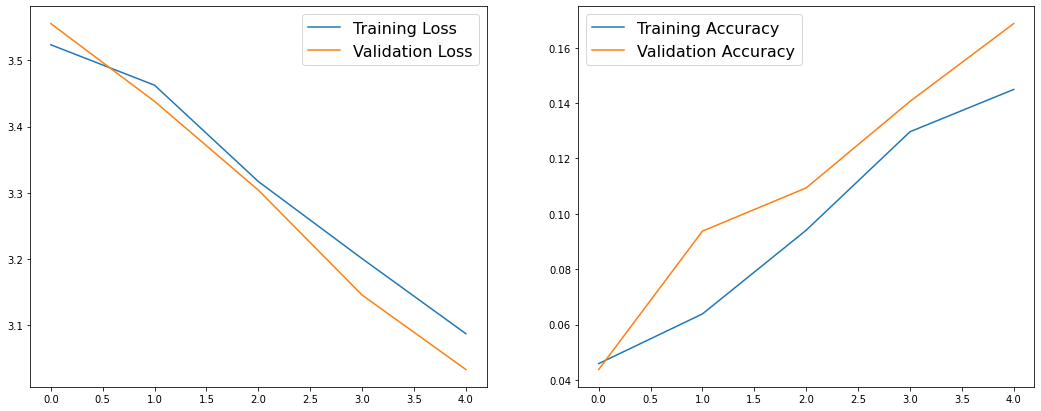

Test set accuracy: 15.384%


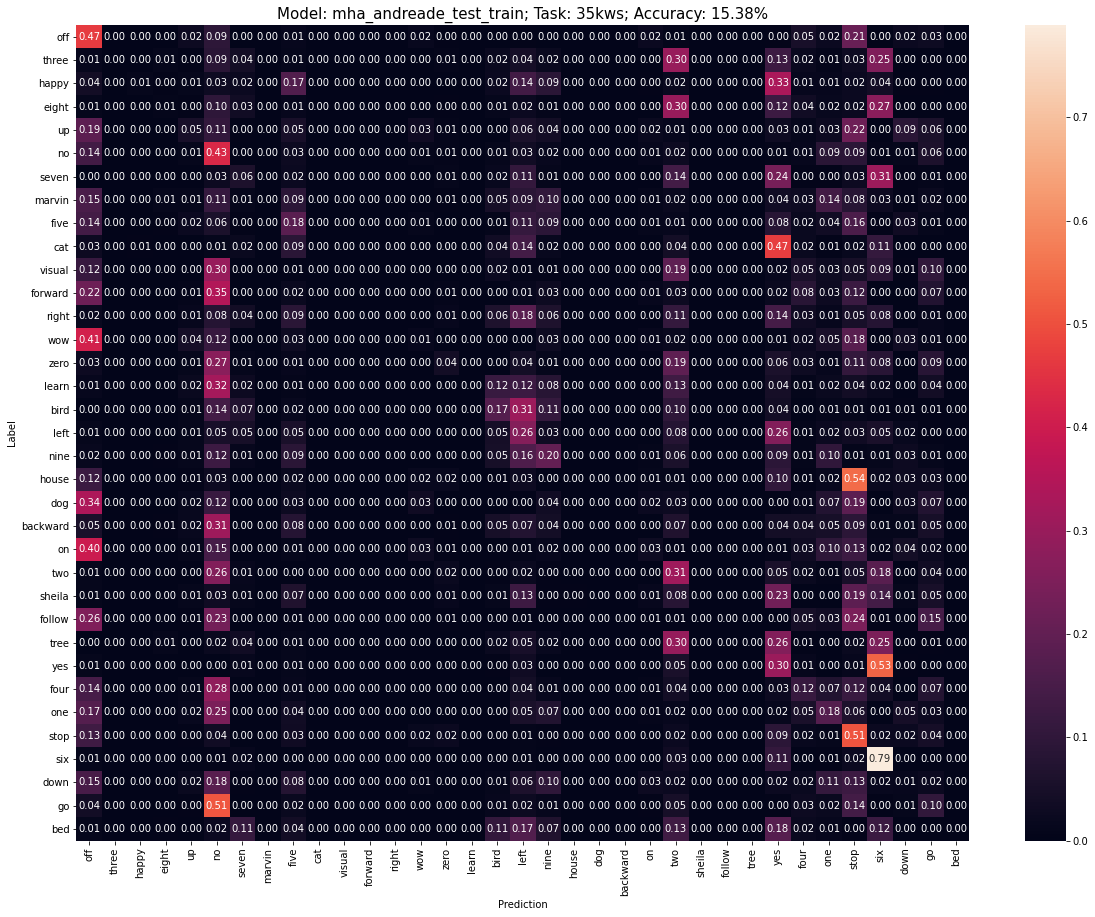

In [45]:
for n_heads in [2,3,4,5]:
    current_mha_model = mha_andreade(train_dataset, output_classes, "test_train", mfccs=True, n_heads=n_heads)
    current_mha_model.load_weights(f"models/{current_task}/mha_andreade_mfccs_{n_heads}heads/weights").expect_partial()
    with (open(f"models/{current_task}/mha_andreade_mfccs_{n_heads}heads/train_history.pkl", "rb")) as openfile:
        history_current_mha_model = pickle.load(openfile)
    plot_learning_curves(history_current_mha_model['train_history'])
    y_scores, att_scores, test_acc = make_confmatrix(current_mha_model, test_dataset)
    results_35kws_task = update_results(results_35kws_task, 
                                    current_mha_model, 
                                    f"MHattRNN_{n_heads}heads", 
                                    y_scores, 
                                    att_scores, 
                                    test_acc)

## ResnetAttention

Input shape: (16000,)


2021-08-27 23:52:47.129223: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


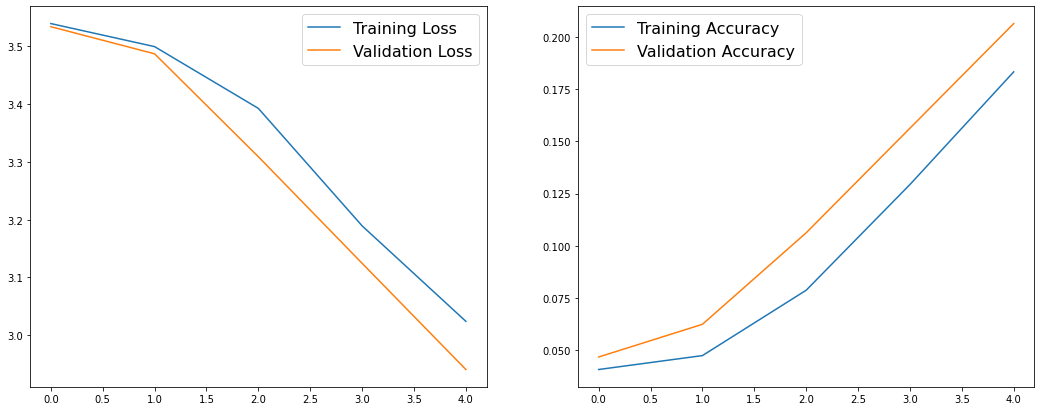

2021-08-27 23:52:49.613187: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 19.791%


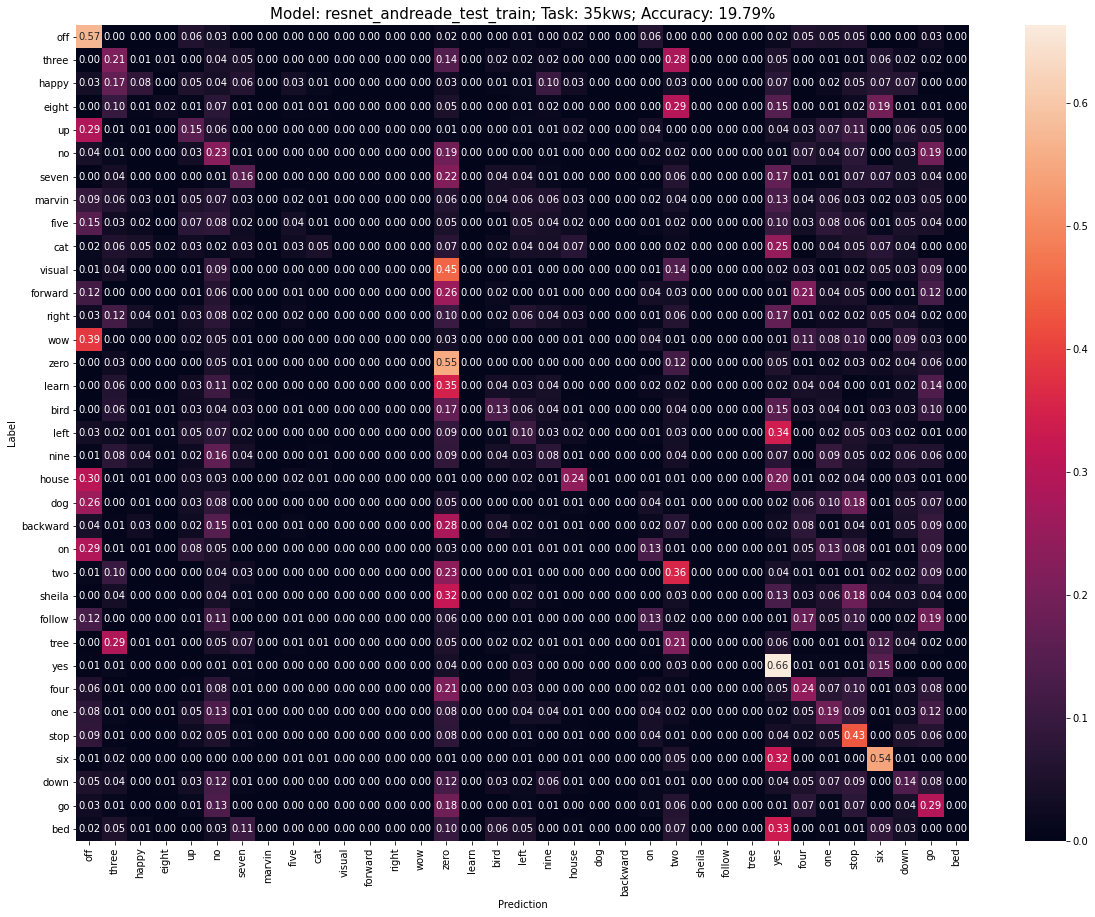

Input shape: (16000,)


2021-08-27 23:52:55.917782: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


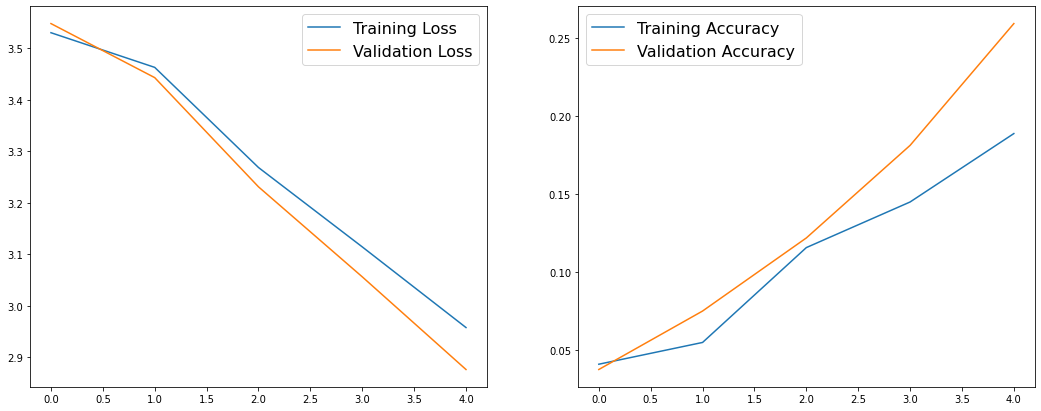

2021-08-27 23:52:58.499380: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 20.482%


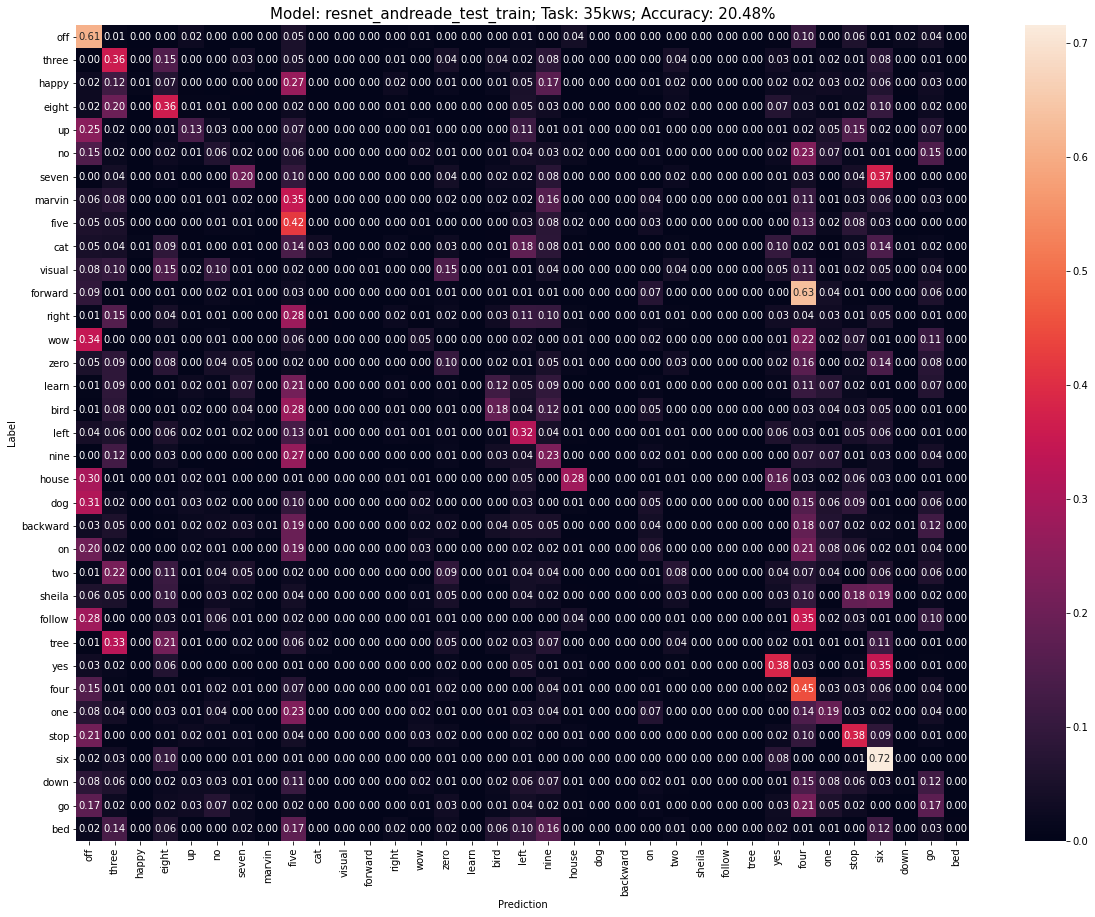

Input shape: (16000,)


2021-08-27 23:53:05.210585: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


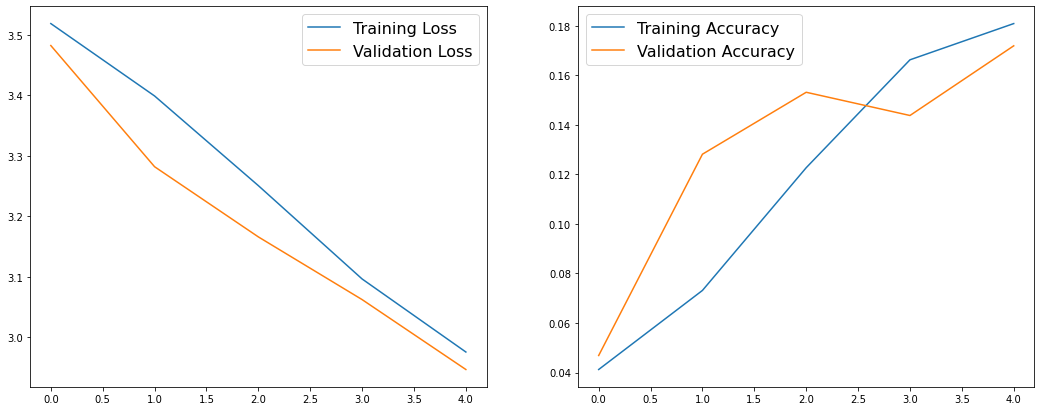

2021-08-27 23:53:07.809001: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5076746240 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 18.155%


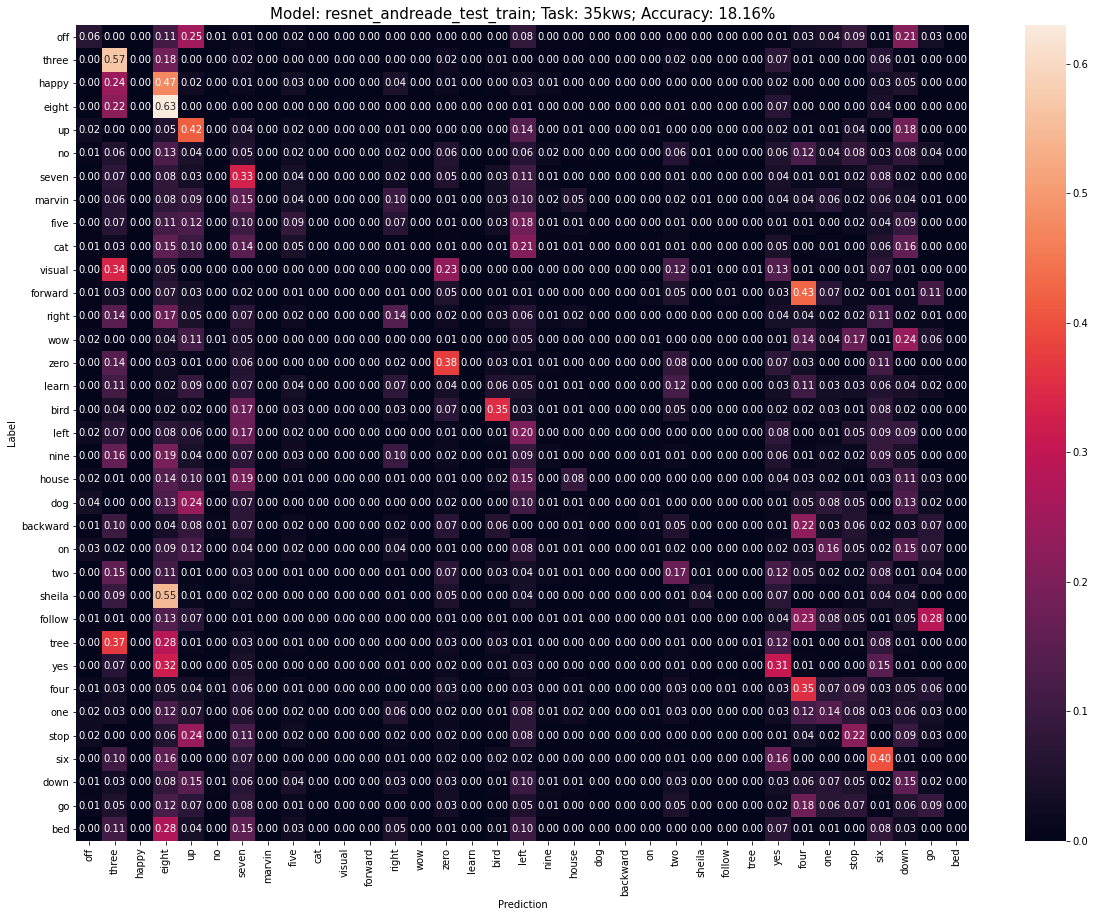

In [46]:
for n_layers in [3,4,5]:
    current_resnet_model = resnet_andreade(train_dataset, output_classes, "test_train", mfccs=True, n_res_blocks=n_layers)
    current_resnet_model.load_weights(f"models/{current_task}/resnet_andreade_mfccs_{n_layers}_layers/weights").expect_partial()
    
    with (open(f"models/{current_task}/resnet_andreade_mfccs_{n_layers}_layers/train_history.pkl", "rb")) as openfile:
        history_current_resnet_model = pickle.load(openfile)
    plot_learning_curves(history_current_resnet_model['train_history'])
    
    y_scores, att_scores, test_acc = make_confmatrix(current_resnet_model, test_dataset)
    results_35kws_task = update_results(results_35kws_task, 
                                    current_resnet_model, 
                                    f"ResAndreade_{n_layers}layers", 
                                    y_scores, 
                                    att_scores, 
                                    test_acc)
    del current_resnet_model

In [47]:
results_35kws_task.keys()

dict_keys(['SimpleAttModel', 'AndreadeOriginal', 'AndreadeSeqQuery', 'SeqQueryNoCNN', 'MHattRNN_2heads', 'MHattRNN_3heads', 'MHattRNN_4heads', 'MHattRNN_5heads', 'ResAndreade_3layers', 'ResAndreade_4layers', 'ResAndreade_5layers'])

In [48]:
## Save all the results to disk
with open(hyperparams._MODELS_DIR_/current_task/'all_results.pkl', 'wb') as outp:
    pickle.dump(results_35kws_task, outp)

# Roc Curves

In [70]:
sns.set_context("paper")

In [49]:
with (open(f"models/10kws+U+S/all_results.pkl", "rb")) as openfile:
        results_12kws_task = pickle.load(openfile)
        
with (open(f"models/35kws/all_results.pkl", "rb")) as openfile:
        results_35kws_task = pickle.load(openfile)

In [50]:
results_12kws_task.keys()

dict_keys(['SimpleAttModel', 'AndreadeOriginal', 'AndreadeSeqQuery', 'SeqQueryNoCNN', 'MHattRNN_2heads', 'MHattRNN_3heads', 'MHattRNN_4heads', 'MHattRNN_5heads', 'ResAndreade_3layers', 'ResAndreade_4layers', 'ResAndreade_5layers'])

In [52]:
results_12kws_task['AndreadeOriginal'].keys()

dict_keys(['y_scores', 'att_scores', 'test_acc', 'n_params', 'fpr', 'fnr', 'roc_auc'])

In [64]:
selected_models = ['SimpleAttModel', 
                   'AndreadeOriginal', 
                   'AndreadeSeqQuery', 
                   'SeqQueryNoCNN', 
                   'MHattRNN_2heads', 
                   'MHattRNN_3heads', 
                   'MHattRNN_4heads', 
#                    'MHattRNN_5heads', 
#                    'ResAndreade_3layers', 
#                    'ResAndreade_4layers', 
                   'ResAndreade_5layers']

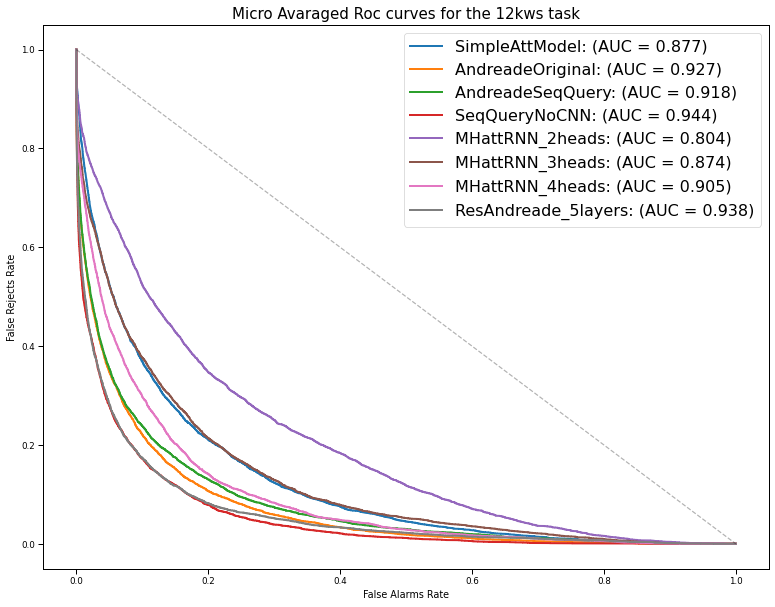

In [75]:
plt.figure(figsize=(13,10))
# for model in ["AndreadeOriginal"]:
# for model in results_12kws_task.keys():
for model in selected_models:
    fpr =results_12kws_task[model]['fpr']
    fnr = results_12kws_task[model]['fnr']
    roc_auc = results_12kws_task[model]['roc_auc']

    plt.plot(fpr["micro"], fnr["micro"],
#              color='deeppink', 
             linestyle='-', linewidth=2, label=f'{model}: (AUC = {round(roc_auc["micro"],3)})')
plt.plot((0,1),(1,0), linestyle="--", color="black", alpha=0.3)
plt.xlabel("False Alarms Rate")
plt.ylabel("False Rejects Rate")
plt.title("Micro Avaraged ROC curves for the 12kws task", fontsize=15)
plt.legend(fontsize=16)
plt.show()

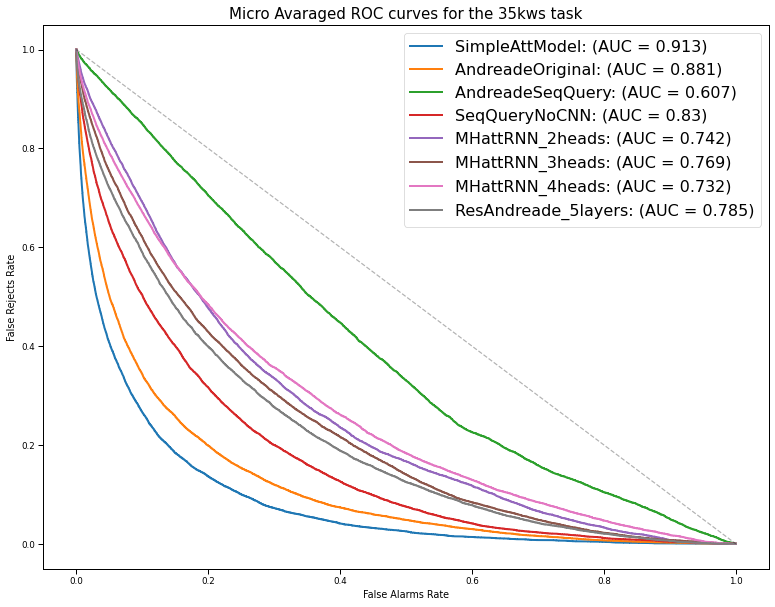

In [77]:
plt.figure(figsize=(13,10))
# for model in ["AndreadeOriginal"]:
# for model in results_12kws_task.keys():
for model in selected_models:
    fpr =results_35kws_task[model]['fpr']
    fnr = results_35kws_task[model]['fnr']
    roc_auc = results_35kws_task[model]['roc_auc']

    plt.plot(fpr["micro"], fnr["micro"],
#              color='deeppink', 
             linestyle='-', linewidth=2, label=f'{model}: (AUC = {round(roc_auc["micro"],3)})')
plt.plot((0,1),(1,0), linestyle="--", color="black", alpha=0.3)
plt.xlabel("False Alarms Rate")
plt.ylabel("False Rejects Rate")
plt.title("Micro Avaraged ROC curves for the 35kws task", fontsize=15)
plt.legend(fontsize=16)
plt.show()

## N.Params vs Accuracy

In [84]:
sns.set_context("paper")

with (open(f"models/10kws+U+S/all_results.pkl", "rb")) as openfile:
        results_12kws_task = pickle.load(openfile)
        
with (open(f"models/35kws/all_results.pkl", "rb")) as openfile:
        results_35kws_task = pickle.load(openfile)

print(results_12kws_task.keys())
print(results_12kws_task['AndreadeOriginal'].keys())

selected_models = ['SimpleAttModel', 
                   'AndreadeOriginal', 
                   'AndreadeSeqQuery', 
                   'SeqQueryNoCNN', 
                   'MHattRNN_2heads', 
                   'MHattRNN_3heads', 
                   'MHattRNN_4heads', 
                   'MHattRNN_5heads', 
                   'ResAndreade_3layers', 
                   'ResAndreade_4layers', 
                   'ResAndreade_5layers']

dict_keys(['SimpleAttModel', 'AndreadeOriginal', 'AndreadeSeqQuery', 'SeqQueryNoCNN', 'MHattRNN_2heads', 'MHattRNN_3heads', 'MHattRNN_4heads', 'MHattRNN_5heads', 'ResAndreade_3layers', 'ResAndreade_4layers', 'ResAndreade_5layers'])
dict_keys(['y_scores', 'att_scores', 'test_acc', 'n_params', 'fpr', 'fnr', 'roc_auc'])


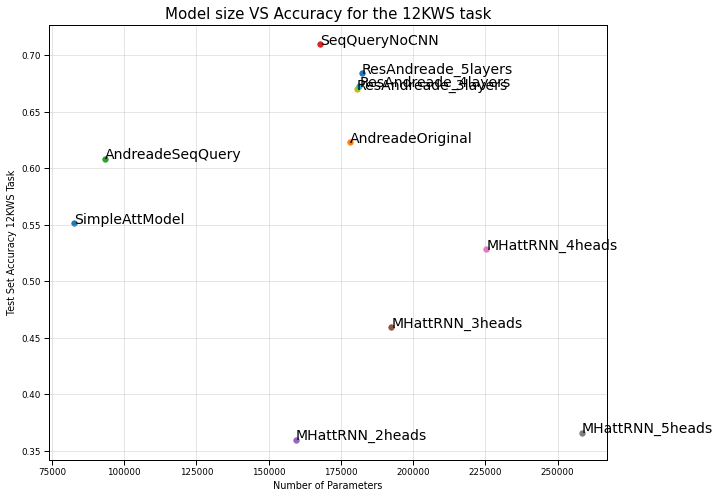

In [97]:
plt.figure(figsize=(10,8))
for model in selected_models:
    pars = results_12kws_task[model]['n_params']
    acc = results_12kws_task[model]['test_acc']
    plt.scatter(pars, acc, s=30)
    plt.text(pars, acc, model, fontsize=14)

plt.xlabel("Number of Parameters")
plt.ylabel("Test Set Accuracy 12KWS Task")
plt.grid(alpha=0.4)
plt.title("Model size VS Accuracy for the 12KWS task", fontsize=15)
plt.show()

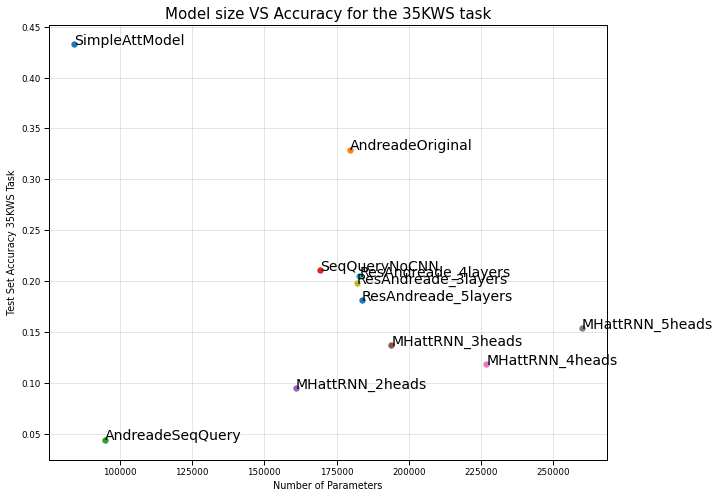

In [98]:
plt.figure(figsize=(10,8))
for model in selected_models:
    pars = results_35kws_task[model]['n_params']
    acc = results_35kws_task[model]['test_acc']
    plt.scatter(pars, acc, s=30)
    plt.text(pars, acc, model, fontsize=14)

plt.xlabel("Number of Parameters")
plt.ylabel("Test Set Accuracy 35KWS Task")
plt.grid(alpha=0.4)
plt.title("Model size VS Accuracy for the 35KWS task", fontsize=15)
plt.show()